# Paper plots

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from pypalettes import load_cmap
import scipy.stats as st
import yaml
import re
import datetime as dt
from itertools import cycle, islice

from mof_benchmark.analysis.plot.plots import style
from mof_benchmark.experiments.scripts.utils import structure_to_files

In [21]:
base_dir = Path("../../")

In [4]:
import os

In [5]:
from ase.eos import EquationOfState
from ase import units

In [6]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
rmse = root_mean_squared_error
mae = lambda x, y: np.mean(np.abs(x-y))

In [7]:
import matplotlib.patches as patches

In [8]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return '#%02x%02x%02x' % tuple([int(v * 255) for v in colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])])

In [9]:
from tueplots import cycler

cmap = load_cmap("Prism")
palette = cmap.colors

plt.rcParams.update(style(column="full", family="sans-serif"))
plt.rcParams.update(cycler.cycler(color=palette))

In [10]:
RED = "#ff1735"
RED_DARK = "#8c061b"
BLACK = "#111"
GREY_DARK = "#37474F" # "#333"
GREY_LIGHT = "#CFD8DC" # "#ccc"
GREY = "#546E7A" # "#555"

In [11]:
text_bbox = dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1")

In [12]:
show_hlines = True

## General settings

In [83]:
calc_names = {
    "your-model": "My Model + D3",
    "orb3": "orb3"
}

In [14]:
all_calcs = [
    "orb3",
]

cmap_all = [
    palette[0]
]

In [15]:
def density_estimation(x, y=None, density_basis=None):
    """Estimate with gaussian kernel density method. Sort by log-density."""
    x = np.asarray(x)

    if y is not None:
        y = np.asarray(y)
        xy_stack = np.vstack([x, y])
    else:
        xy_stack = x[None, :]
    threshold = 500
    z = st.gaussian_kde(xy_stack[:, np.random.choice(x.shape[0], threshold, replace=False)] if len(x) > threshold else xy_stack)(xy_stack)
    z_sort = np.argsort(z)
    x = x[z_sort]
    if y is not None:
        y = y[z_sort]
    z = z[z_sort]
    z = np.log(z - np.min(z) + 1)  # ensure valid log domain
    if density_basis is not None:
        z /= np.log(density_basis)
    return x, y, z, z_sort

def scatter_density(x, y, ax, **kwargs):
    x, y, z, _ = density_estimation(x, y)
    ax.scatter(x, y, c=z, **kwargs)

In [16]:
def generate_violin_plot(y_data, ax, colors=None, scatter_kwargs={}, scatter_rasterized=False, plot_density=True, density_basis=None):
    POSITIONS = np.arange(len(y_data))
    
    violins = ax.violinplot(
        y_data, 
        positions=POSITIONS,
        widths=0.65,
        bw_method="silverman",
        showmeans=False, 
        showmedians=False,
        showextrema=False,
    )
    
    for pc in violins["bodies"]:
        pc.set_facecolor("none")
        pc.set_edgecolor(BLACK)
        pc.set_linewidth(0.7)
        pc.set_alpha(1)
        pc.set_zorder(2)
    
    ### BOXPLOT
    
    medianprops = dict(
        linewidth=1, 
        color=RED_DARK,
        solid_capstyle="butt"
    )
    boxprops = dict(
        linewidth=0.8, 
        color=GREY_DARK
    )
    
    ax.boxplot(
        y_data,
        positions=POSITIONS, 
        showfliers = False, # Do not show the outliers beyond the caps.
        showcaps = False,   # Do not show the caps
        medianprops = medianprops,
        whiskerprops = boxprops,
        boxprops = boxprops,
        widths=0.4
    )
    
    jitter = 0.06
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
    x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x), random_state=0) for x in x_data]

    cmap =  matplotlib.colormaps["mako"]
    hex_values = [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, 6)]

    colors = colors or list(islice(cycle(palette), len(x_jittered)))
    
    for x, y, color in zip(x_jittered, y_data, colors):
        _, _, z, z_sort = density_estimation(y, density_basis=density_basis)
        x = np.asarray(x)
        y = np.asarray(y)

        _defaults = {"s": 20, "alpha": 0.5, "rasterized": scatter_rasterized}
        if plot_density:
            adapted_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [color] + hex_values[3:])
            ax.scatter(x[z_sort], y[z_sort], **{"c": z, "cmap": adapted_cmap if plot_density else color, **_defaults, **scatter_kwargs})
        else:
            ax.scatter(x[z_sort], y[z_sort], **{"c": color, **_defaults, **scatter_kwargs})

    return ax

# Energy comparison

In [23]:
reference = base_dir / "experiments" / "structures" / "qmof_database" / "qmof.csv"
reference_df = pd.read_csv(reference)

/scratch/slurm_tmpdir/job_464200/ipykernel_1928374/52301569.py:2: DtypeWarning: Columns (40,41,43,44,45,46,47,49,50,51,52,53,55,56,57,65,66,67,68,69,77,78,79,80,81,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  reference_df = pd.read_csv(reference)


In [24]:
len(reference_df)

20373

In [25]:
energy_base = base_dir / "outputs" / "qmof_energy"

In [27]:
energy_calcs = os.listdir(energy_base)

all_calcs_energy = all_calcs.copy()

energy_diffs = []
energy_rmse = []
energy_mae = []
energy_std = []
n_structures = []

for i, calc in tqdm(enumerate(all_calcs_energy), total=len(all_calcs_energy)):
    if calc not in energy_calcs:
        energy_diffs.append([0])
        energy_rmse.append(-1)

    calc_df = pd.read_parquet(energy_base / calc / "v1" / f"{calc}.parquet")
    df = calc_df.merge(reference_df, left_on="structure", right_on="qmof_id")

    energy_diffs.append((df["energy"]-df["outputs.pbe.energy_total"])/df["info.natoms"])
    energy_rmse.append(root_mean_squared_error(df["energy"]/df["info.natoms"], df["outputs.pbe.energy_total"]/df["info.natoms"]))
    energy_mae.append(np.mean(np.abs((df["energy"]/df["info.natoms"]- df["outputs.pbe.energy_total"]/df["info.natoms"]))))
    energy_std.append(np.std(np.abs((df["energy"]/df["info.natoms"]- df["outputs.pbe.energy_total"]/df["info.natoms"]))))
    n_structures.append(len(df))

FileNotFoundError: [Errno 2] No such file or directory: '../../outputs/qmof_energy'

In [28]:
fig, ax = plt.subplots(np.ceil(len(all_calcs_energy) / 4).astype(int),4, figsize=(8,np.ceil(len(all_calcs_energy) / 4).astype(int) * 1.7), sharex=True, sharey=True, constrained_layout=True)
ax = ax.ravel()

energy_calcs = os.listdir(energy_base)

for i, calc in enumerate(all_calcs_energy):
    if calc not in energy_calcs:
        continue

    try:
        calc_df = pd.read_parquet(energy_base / calc / "v1" / f"{calc}.parquet")
    except:
        continue
    df = calc_df.merge(reference_df, left_on="structure", right_on="qmof_id")

    ax[i].plot([-8.5, -4], [-8.5, -4], c=GREY, zorder=-1)
    ax[i].set_xlim([-8.5, -4])
    ax[i].set_ylim([-8.5, -4])
    scatter_density(df["outputs.pbe.energy_total"] / df["info.natoms"], df["energy"] / df["info.natoms"], ax=ax[i], s=2, alpha=0.5, cmap="viridis", rasterized = True)
    ax[i].set_title(calc_names[calc].replace("\n", " "))
    if i in [0,4,8,12]:
        ax[i].set_ylabel("uMLIP E/atom (eV)")
    if i in [20,19,18,17]:
        ax[i].set_xlabel("DFT E/atom (eV)")
    ax[i].text(0.04, 0.95, f"{energy_mae[i]:.3f} eV/atom\n({len(df)})", horizontalalignment="left", verticalalignment="top", transform = ax[i].transAxes, size=7)

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# ax[-5].xaxis.set_tick_params(which='both', labelbottom=True)
# ax[-6].xaxis.set_tick_params(which='both', labelbottom=True)
# ax[-7].xaxis.set_tick_params(which='both', labelbottom=True)

# fig.tight_layout()
fig.savefig("figures/qmof_pot_eng_parity.pdf")

NameError: name 'all_calcs_energy' is not defined

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,2.5))

generate_violin_plot(energy_diffs, ax, scatter_kwargs={"alpha": 0.8, "s": 3, "rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs_energy)), [calc_names[key] for key in all_calcs_energy], rotation=45, ha="right")

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

for x, calc in enumerate(all_calcs_energy):
    i = all_calcs_energy.index(calc)
    ax.text(x, min(energy_diffs[i].max() + 0.1,0.95), f"{energy_mae[i]:.3f}", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=text_bbox)
    ax.text(x, -1.21, f"({n_structures[i]})", horizontalalignment="center", verticalalignment="bottom", size=5.5, bbox=text_bbox)

ax.set_xlim([-0.5,len(all_calcs_energy) - 0.5])
ax.set_ylim([-1.23,1.1])

ax.set_ylabel("$\\Updelta$ Potential energy (eV/atom)", size=7)

fig.savefig("figures/qmof_pot_eng_all.pdf")

In [25]:
from mof_benchmark.analysis.common.utils import METAL_ELEMENTS

In [26]:
from pymatviz import ptable_heatmap_plotly, ptable_heatmap_splits_plotly

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [27]:
def is_metal(symbol):
    return symbol in METAL_ELEMENTS

In [28]:
def process_formula(formula, only_metal = False):
    extracted = re.findall("[A-Z][a-z]?|[0-9]+", formula)
    prev = extracted[0]
    if len(extracted) == 1:
        return [(prev, 1)]

    element_counts = []
    for t in extracted[1:]:
        if t.isdigit() and (is_metal(prev) or not only_metal):
                element_counts.append((prev, int(t)))
        elif not prev.isdigit() and (is_metal(prev) or not only_metal):
            element_counts.append((prev, 1))

        prev = t

    if not prev.isdigit() and (is_metal(prev) or not only_metal):
        element_counts.append((prev, 1))

    return element_counts

In [29]:
reference_df["info.formula.counts"] = list(map(process_formula, reference_df["info.formula"]))

In [30]:
qmof_elements = set([r[0] for d in reference_df["info.formula.counts"] for r in d])
# qmof_elements = set([r[0] for d in reference_df["info.formula.counts"] for r in d if is_metal(r[0])])

In [31]:
element_counts = {e: 0 for e in qmof_elements}
for row in reference_df["info.formula.counts"]:
    for e, v in row:
        element_counts[e] += v

In [32]:
table_maes = []
for i, calc in tqdm(enumerate(all_calcs), total=len(all_calcs)):
    per_atom_diffs = {e: [] for e in qmof_elements}

    calc_df = pd.read_parquet(energy_base / calc / "v1" / f"{calc}.parquet")
    df = calc_df.merge(reference_df, left_on="structure", right_on="qmof_id")

    energy_diffs = (df["energy"]-df["outputs.pbe.energy_total"]) / (df["info.natoms"])

    for i, row in df.iterrows():
        n_metals = sum([v for k, v in row["info.formula.counts"] if is_metal(k)])
        for element, count in row["info.formula.counts"]:
            per_atom_diffs[element] += [energy_diffs[i]] * count
    
    per_atom_diffs = {e: abs(np.array(v)).mean() * 1000 for e,v in per_atom_diffs.items() if len(v) > 0}

    table_maes.append(per_atom_diffs)

100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


In [35]:
import plotly.io as pio
pio.renderers.default = "svg"

/home/tu/tu_tu/tu_zxoyu44/miniforge3/envs/mof_benchmark/lib/python3.12/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



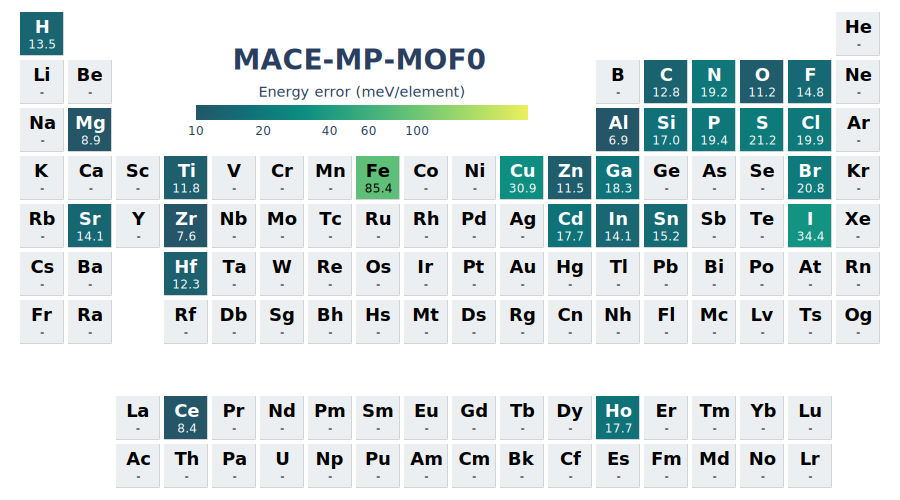

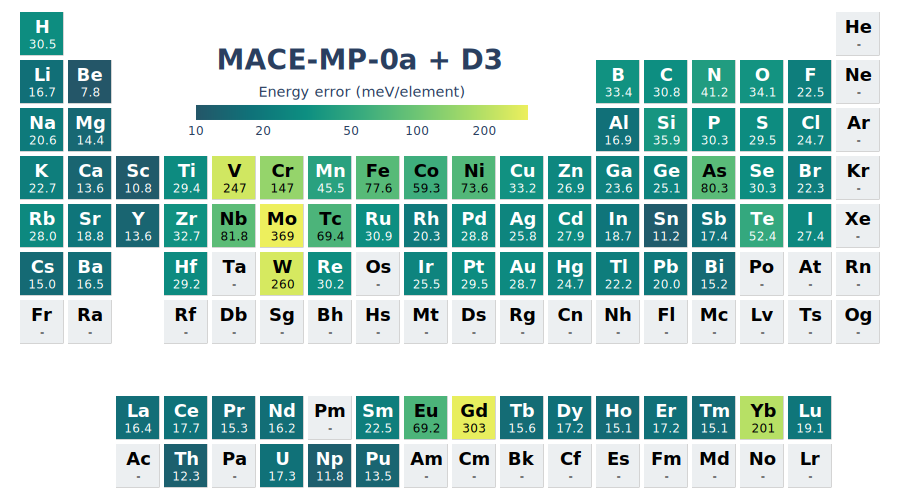

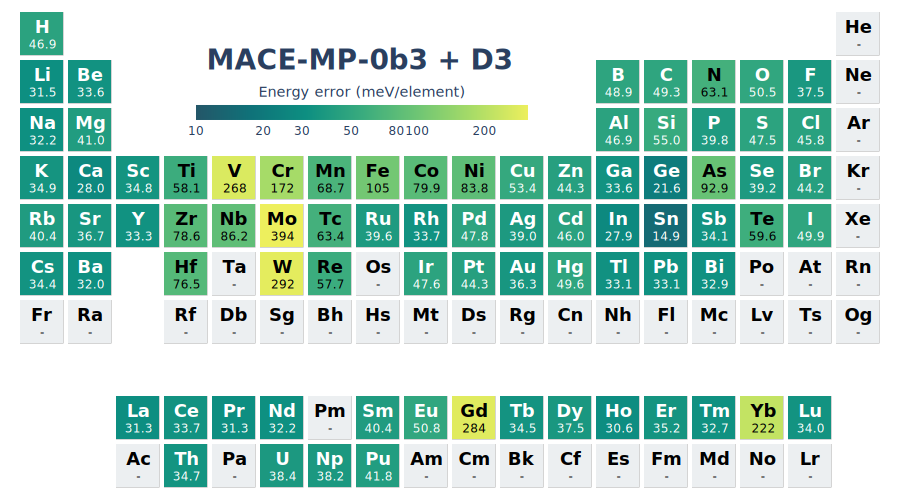

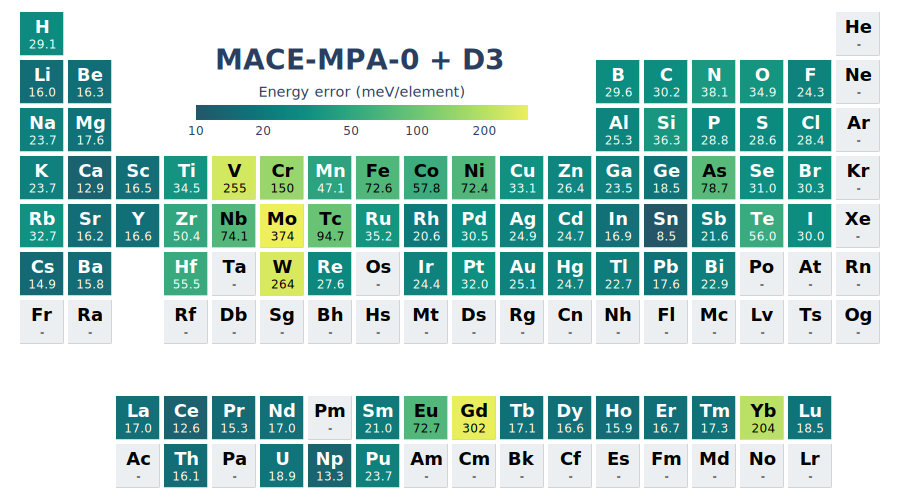

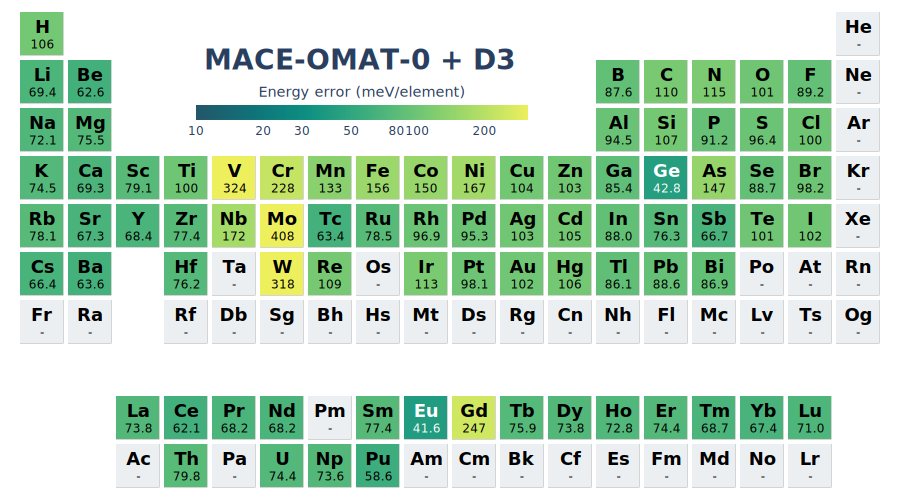

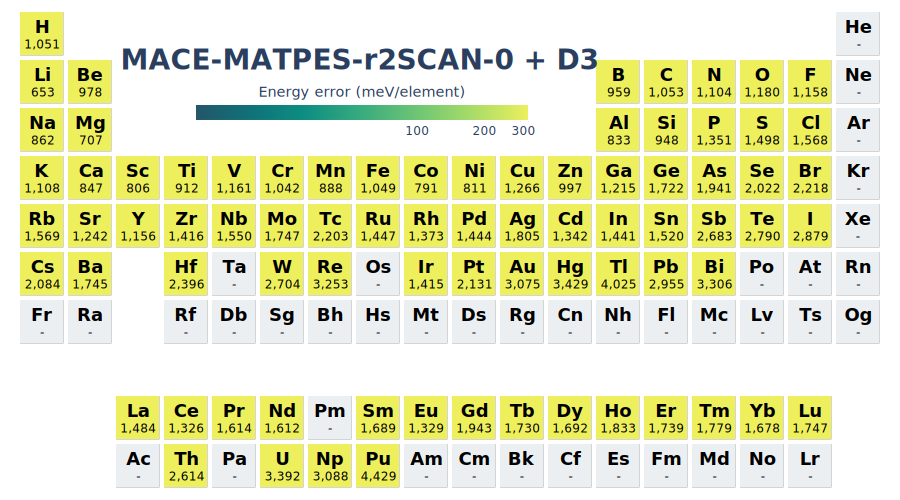

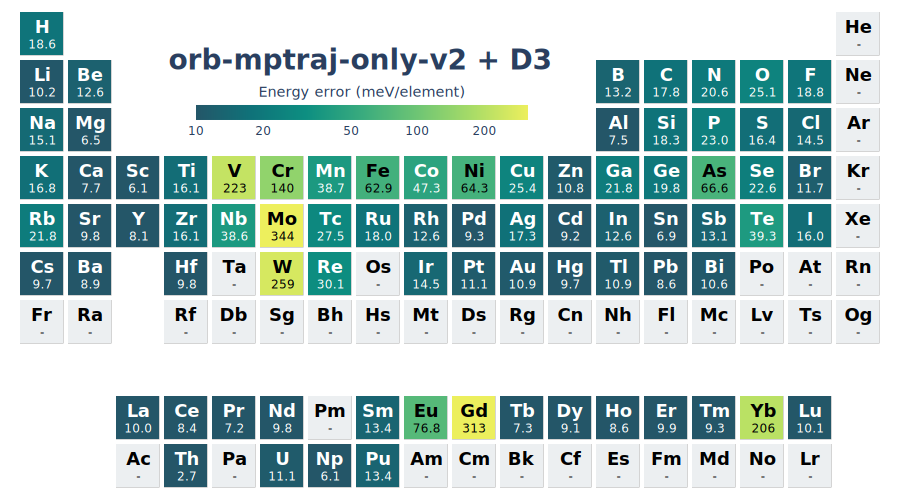

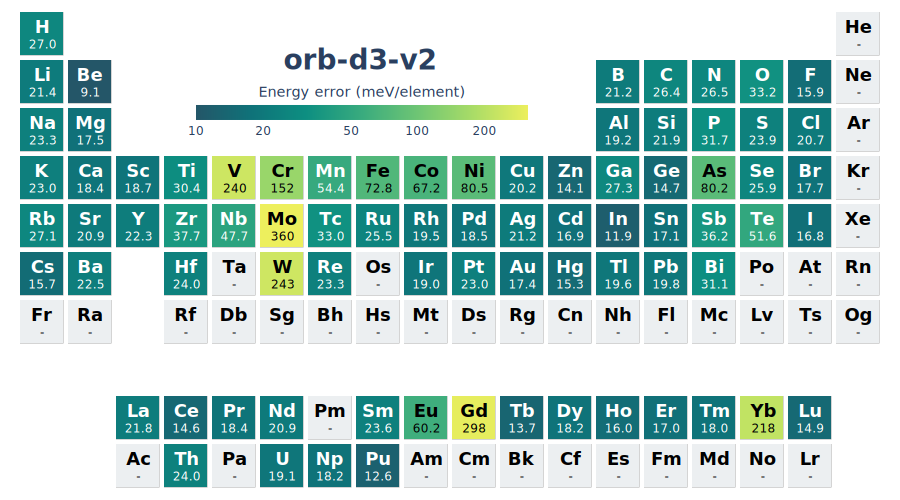

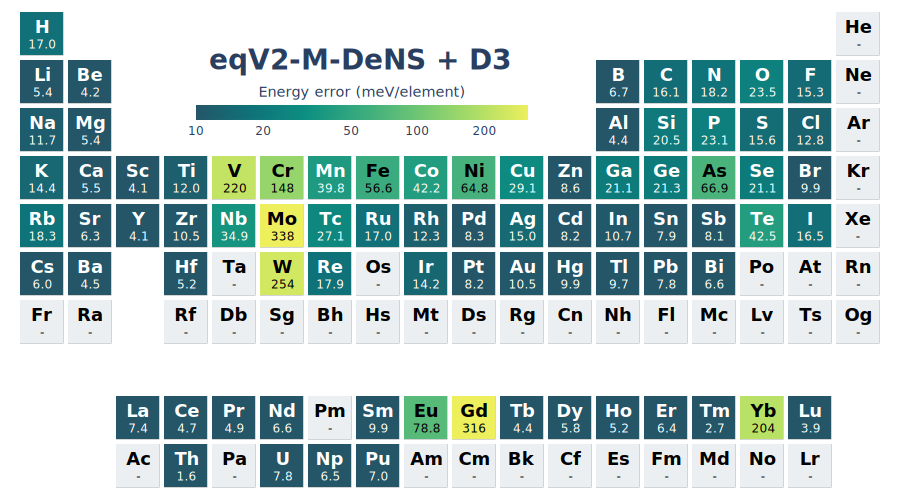

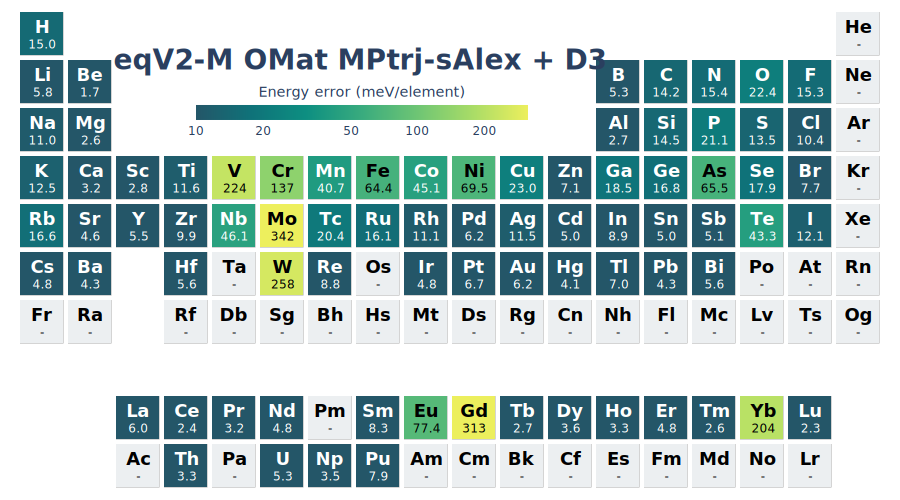

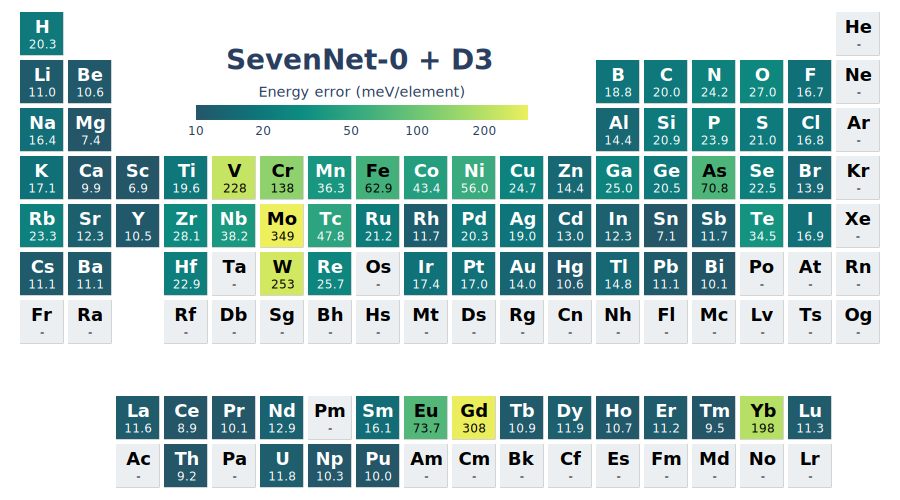

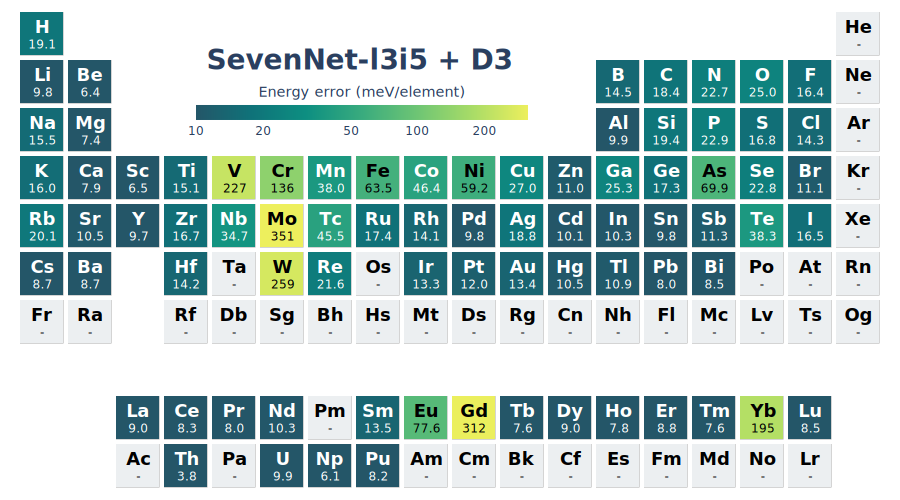

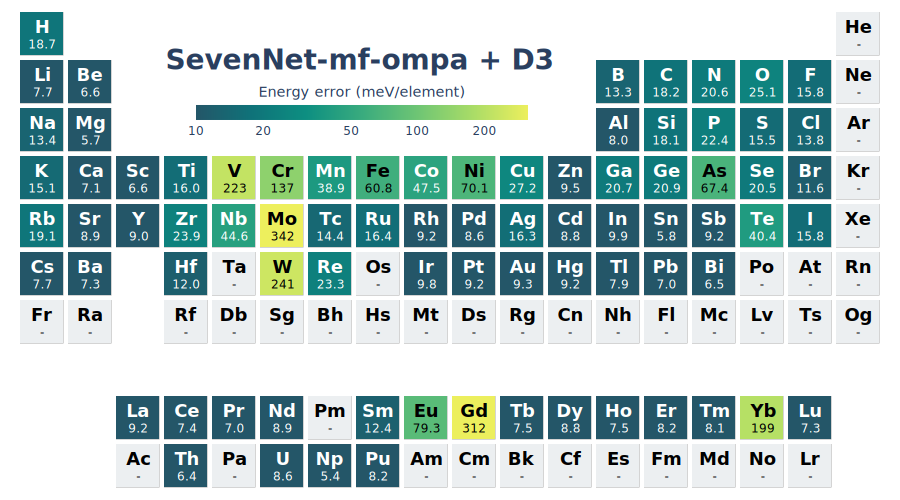

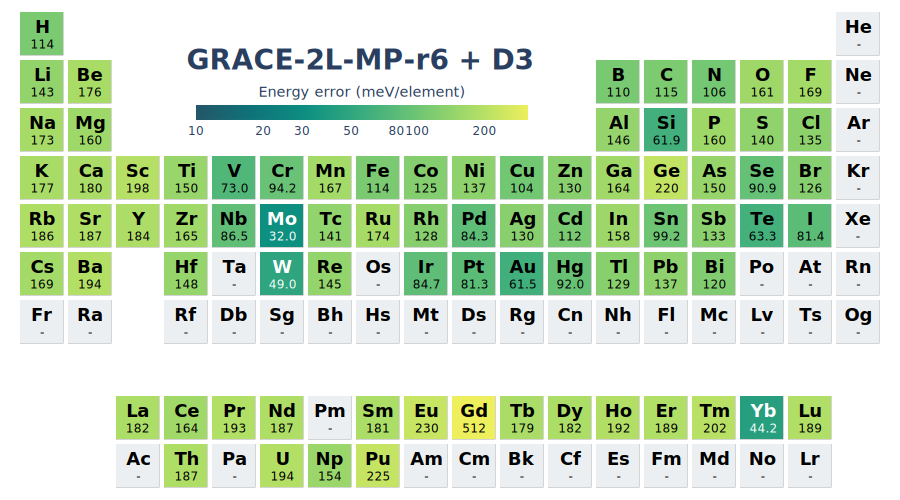

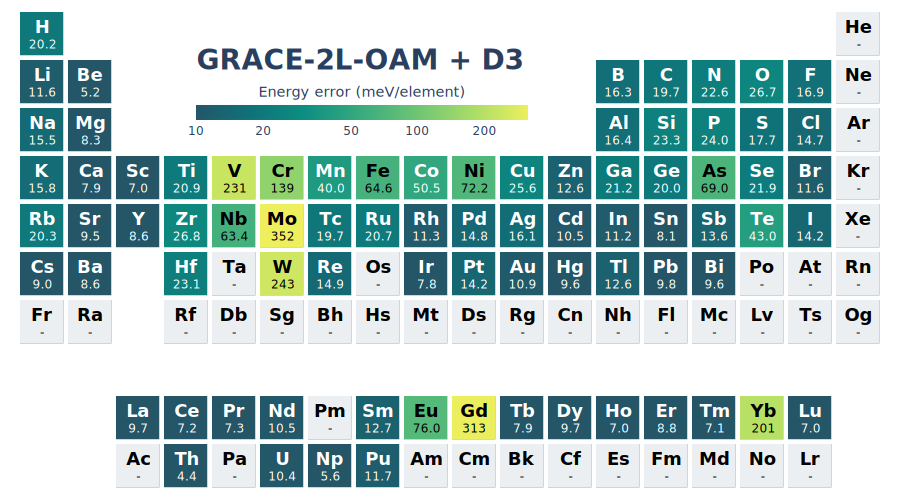

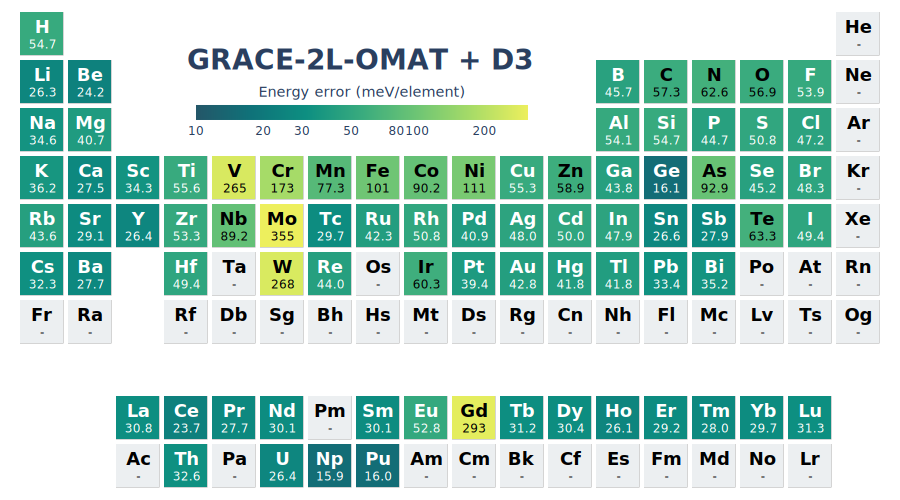

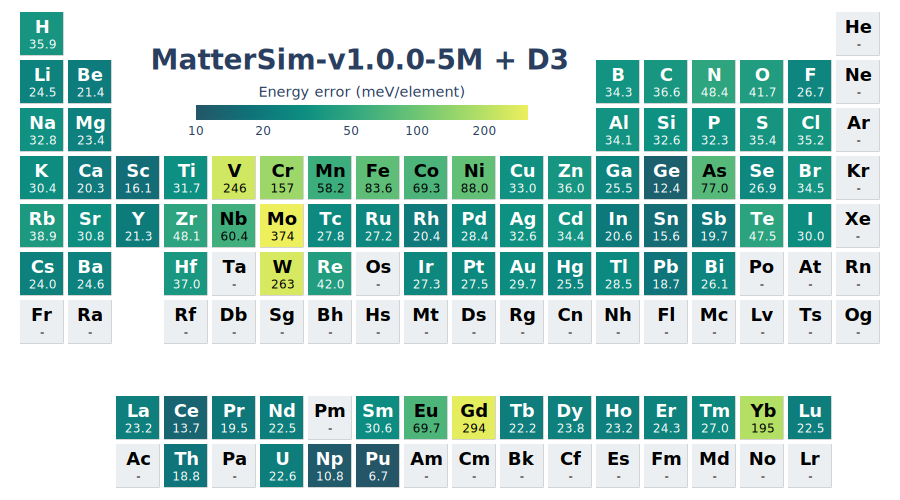

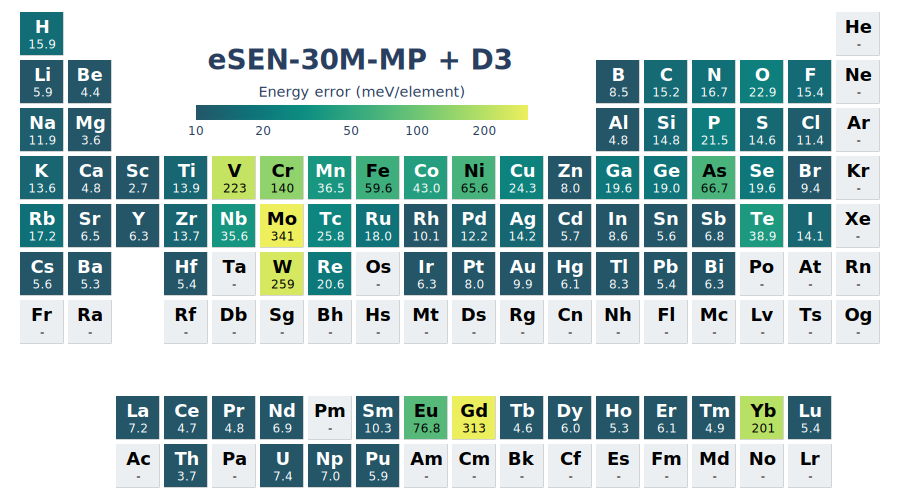

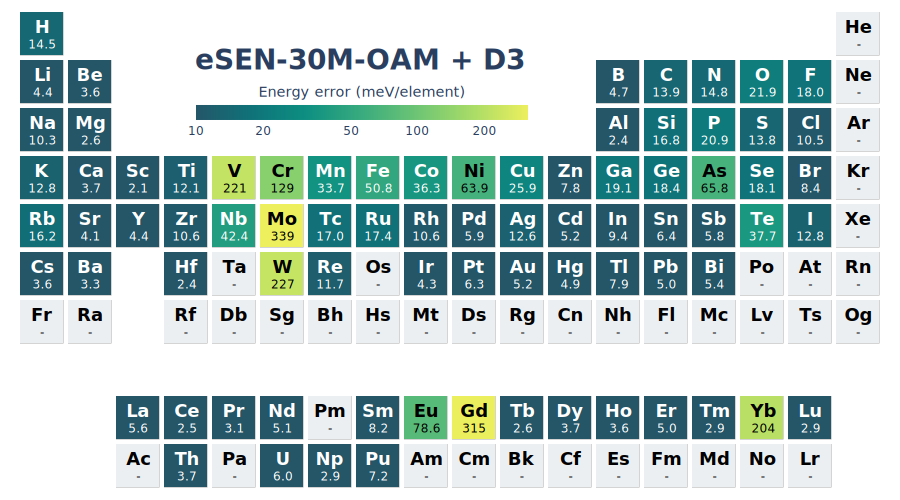

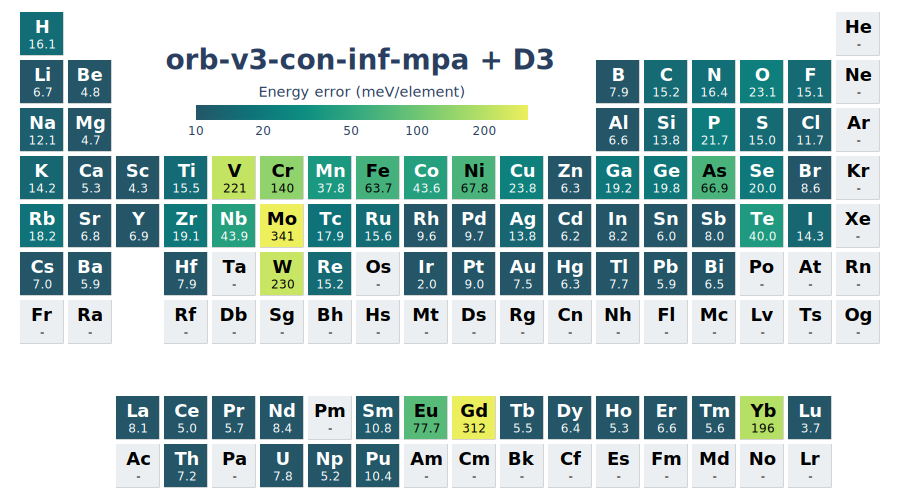

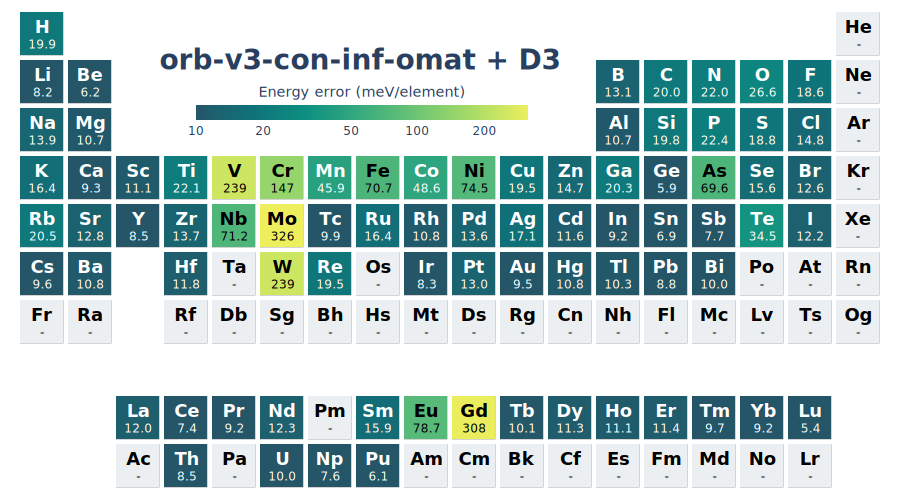

In [36]:
for calc in all_calcs:
    fig = ptable_heatmap_plotly(values=table_maes[all_calcs.index(calc)], log=True, nan_color="#ECEFF1", colorscale="aggrnyl", cscale_range=(1,2.5), colorbar={"title": "Energy error (meV/element)"})
    fig.layout.title = dict(text="<b>"+calc_names[calc]+"</b>", x=0.4, y=0.9, font=dict(size=28))
    fig.show()
    fig.write_image(f"figures/ptable_mae_{calc}.pdf")

# Optimization

In [65]:
optimization_results_file = (
    base_dir / "analysis" / "results" / "optimization_results.parquet"
)

optimization_rmsd = pd.read_parquet(optimization_results_file)
selected_settings = "optimization.yaml"

df = optimization_rmsd
df = df[df.index.get_level_values("settings").str.endswith(selected_settings)]

In [68]:
# initial structures vs dft
rmsd_experimental_to_dft = np.asarray([1.51300977, 0.52366041, 2.5872095, 2.91469591, 0.62078246, 3.98770929, 0.45760085, 2.44440829, 0.52093554, 0.39179915, 0.16593501, 2.3093359, 2.40593929, 0.27938263, 3.41304821, 3.36022029, 6.08912896, 3.46009604, 0.07802425, 0.20937194, 7.72162355, 0.10754219, 7.38415897, 0.08448259, 4.06418549, 6.96467978, 0.24750341, 10.33001237])
volume_change_exp_to_dft = np.asarray([0.04677049528537217,0.002029825842398824,0.028388028484265537,-0.02353915072588361,-0.06183869011034222,-0.012718032949551006,0.057433662309718275,0.01946988276634999,0.0034174478215002694,-0.01578801090945494,-0.01741101309029063,-0.009108529636912652,0.006022389961253198,0.006474400297147039,0.033914795223985265,0.06539443058769792,0.021308923095620227,0.08053422908303565,0.008490433136759819,0.004775444048641929,0.024960223876645888,0.0280740526762165,-0.014969280219698403,0.014440539590907653,0.035673447649345616,-0.0012502359317376301,-0.0018911648451582443,0.01318004430810435])

### Volume vs DFT

In [69]:
structures = []
vol_diffs = []
vol_diffs_1000 = []
vol_diffs_dft = []
vol_diffs_dft_1000 = []
last_steps = []
failed_structures = []

for calc in tqdm(all_calcs):
    calc_structures = []
    calc_volume_change_rel_dft = []
    calc_volume_change_rel_dft_1000 = []
    calc_volume_change_rel = []
    calc_volume_change_rel_1000 = []
    calc_last_steps = []

    df_calc = df[df.index.get_level_values("calculator") == calc]
    for structure in df_calc.index.get_level_values("structure").unique():
        
        row = df_calc[df_calc.index.get_level_values("structure") == structure].iloc[0]

        # Get last step volume vs DFT volume if DFT volume available
        if row["dft_volume"] is not None and not np.isnan(
            row["dft_volume"]
        ):
            calc_volume_change_rel_dft.append((row["volume"][-1] - row["dft_volume"]) / row["dft_volume"] * 100)
            calc_volume_change_rel_dft_1000.append((row["volume"][min(1000, len(row["volume"]) - 1)] - row["dft_volume"]) / row["dft_volume"] * 100)
        else:
            calc_volume_change_rel_dft.append(None)
            calc_volume_change_rel_dft_1000.append(None)

        # Get last step index
        calc_volume_change_rel.append((row["volume"][-1] - row["volume"][0]) / row["volume"][0] * 100)
        calc_volume_change_rel_1000.append((row["volume"][min(1000, len(row["volume"]) - 1)] - row["volume"][0]) / row["volume"][0] * 100)
        calc_structures.append(structure)
        calc_last_steps.append(row["step"][-1])

    structures.append(calc_structures)
    vol_diffs_dft.append(calc_volume_change_rel_dft)
    vol_diffs_dft_1000.append(calc_volume_change_rel_dft_1000)
    vol_diffs.append(calc_volume_change_rel)
    vol_diffs_1000.append(calc_volume_change_rel_1000)
    last_steps.append(calc_last_steps)

analysis_df = pd.DataFrame({
    "structure": structures,
    "vol_diff_dft": vol_diffs_dft,
    "vol_diff_dft_1000": vol_diffs_dft_1000,
    "vol_diff": vol_diffs,
    "vol_diff_1000": vol_diffs_1000,
    "last_step": last_steps,
    "calculator": all_calcs,
}).explode(["structure", "vol_diff_dft", "vol_diff", "vol_diff_dft_1000", "vol_diff_1000", "last_step"])

100%|██████████| 1/1 [00:00<00:00, 198.65it/s]


## Volume difference to DFT (no fine-tuned failed structures)

### Percent of failed (>+-10% volume) structures

In [72]:
failed_per_calculator = analysis_df[~analysis_df["vol_diff_dft"].isna()].groupby("calculator")["vol_diff_dft"].agg(lambda x: (np.abs(x) > 10).sum())
successfully_computed_per_calculator = analysis_df[~analysis_df["vol_diff_dft"].isna()].groupby("calculator")["vol_diff_dft"].agg(len)
percent_failed = failed_per_calculator / successfully_computed_per_calculator * 100
percent_failed

calculator
orb3    42.105263
Name: vol_diff_dft, dtype: float64

In [73]:
non_existing = analysis_df[~analysis_df["vol_diff_dft"].isna()]["structure"].unique()

In [74]:
df = pd.read_csv("../dft_data/1st_2nd_final_filter_good_bulk_modulus_calc_info_combined.csv")

In [75]:
df["structure"].unique().shape

(101,)

### failed structures per calculator

In [77]:
temp = analysis_df[~analysis_df["vol_diff_dft"].isna()]
temp = temp[np.abs(temp["vol_diff_dft"]) > 10].groupby("calculator")["structure"].agg(list)
for i, calc in enumerate(temp.index):
    print(f"{calc} failed:")
    print(", ".join(temp.iloc[i]))

orb3 failed:
boydwoo_str_m3_o23_o28_pcu_sym_68, boydwoo_str_m3_o1_o22_nbo_sym_166, boydwoo_str_m3_o3_o27_pcu_sym_138, boydwoo_str_m3_o7_o27_pcu_sym_8, gmof_Zn2O8-irmof8_A-NCO_A_No14, tobacco_bor_sym_3_mc_0_sym_4_on_6_L_19, gmof_AlO6-DPAC_A_No31, gmof_AlO6-ADC_A_No11


### element distribution of failed structures

In [78]:
from ase.io import read
from collections import Counter
import functools

In [79]:
temp = analysis_df[~analysis_df["vol_diff_dft"].isna()]
temp = temp[np.abs(temp["vol_diff_dft"]) > 10].groupby("calculator")["structure"].agg(list)

all_chemical_symbols = []

@functools.cache
def get_chemical_symbols(file):
    atoms = read(file)
    return atoms.get_chemical_symbols()

for i, calc in enumerate(temp.index):
    
    for structure in temp.iloc[i]:
        chemical_symbols = get_chemical_symbols(base_dir / "experiments" / "structures" / "main_set" / (structure + ".cif"))
        all_chemical_symbols.extend(chemical_symbols)

symbol_distribution = Counter(all_chemical_symbols)

In [80]:
symbol_distribution

Counter({'C': 503,
         'H': 311,
         'O': 114,
         'N': 93,
         'Cl': 40,
         'Zn': 16,
         'Cu': 12,
         'Al': 4})

## Volume difference to DFT

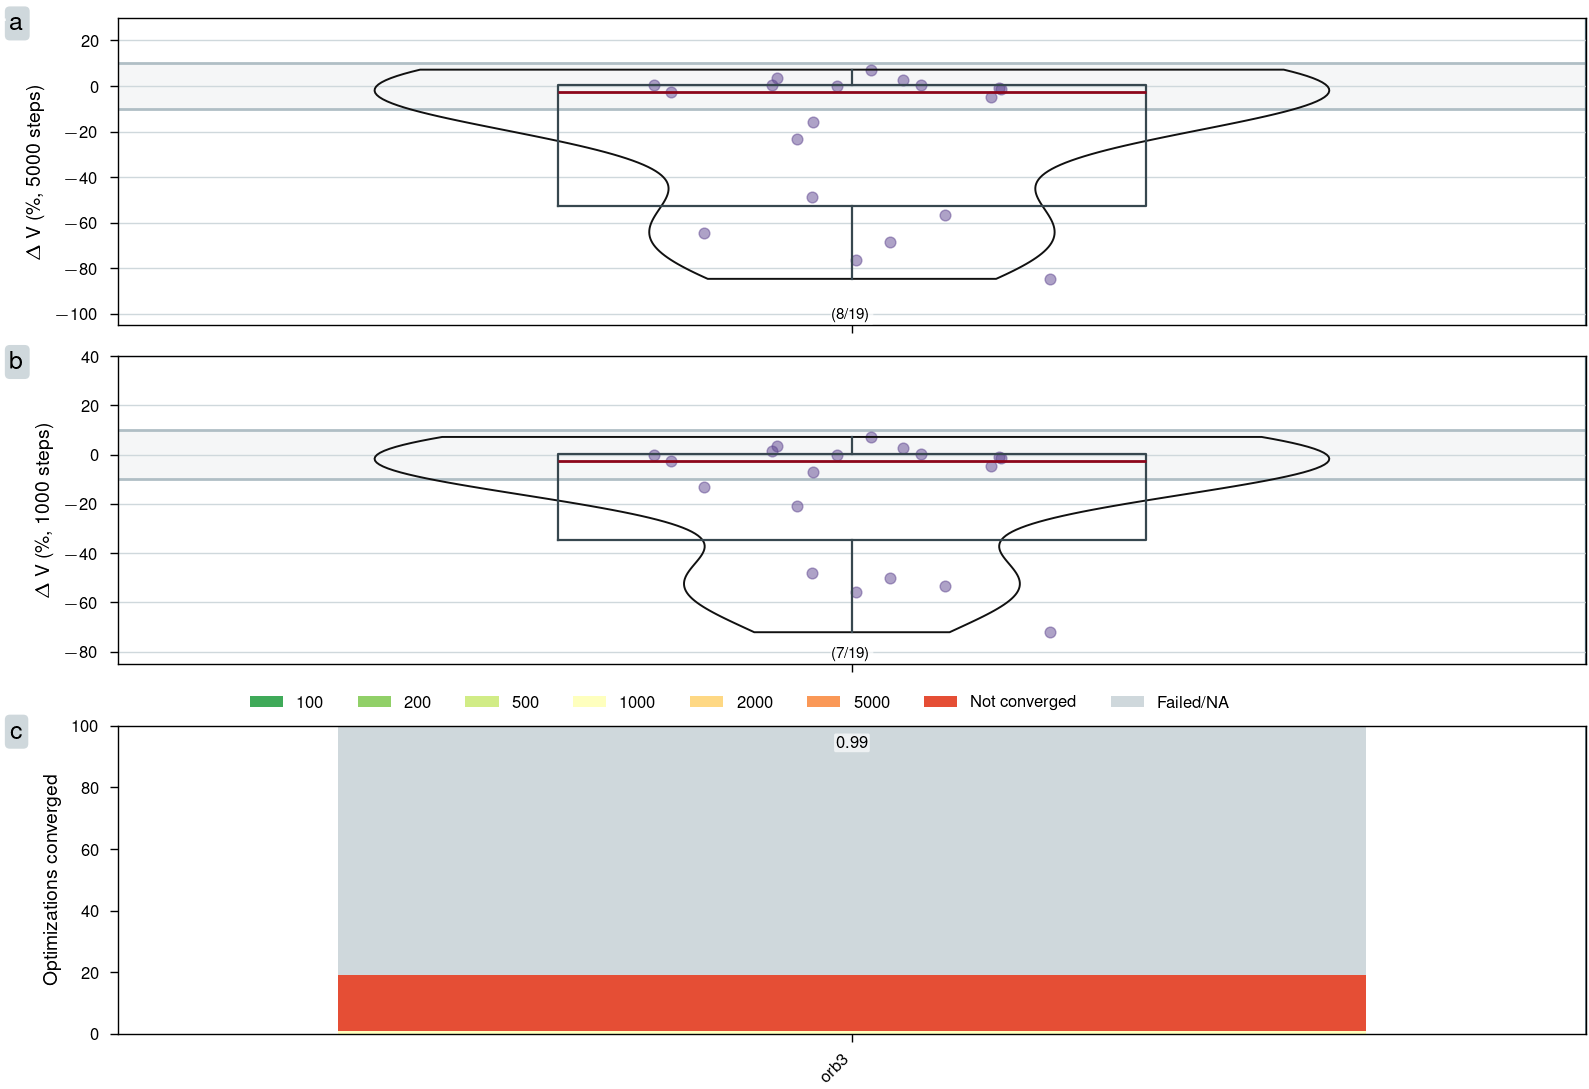

In [84]:
fig, axs = plt.subplots(3, 1, figsize=(8,5.5), sharex=True, constrained_layout=True)

ax = axs[0]

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

y_data = analysis_df
y_data = y_data[~y_data["vol_diff_dft"].isna()]
y_data = y_data.groupby("calculator")["vol_diff_dft"].apply(list).loc[all_calcs]

## VIOLIN PLOT
generate_violin_plot(y_data, ax, plot_density=False, scatter_kwargs={"s": 15, "rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([-105,30])
ax.set_xlim([-0.5, len(all_calcs) - 0.5])

rect = patches.Rectangle((-1, 10), len(all_calcs)+1, -20, linewidth=1, edgecolor="#B0BEC5", facecolor="#B0BEC5" + "20", zorder=-10)
ax.add_patch(rect) 

for x, calc in enumerate(all_calcs):
    ax.text(x, -104, f"({failed_per_calculator.loc[calc]}/{successfully_computed_per_calculator.loc[calc]})", horizontalalignment="center", verticalalignment="bottom", size=5.5, bbox=text_bbox)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.annotate(
    "a",
    xy=(-0.09, 1.1), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="9", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", boxstyle="round,pad=0.22,rounding_size=0.2")
)
ax.annotate(
    ".",
    c="white",
    xy=(-0.095, 1.13), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="9", verticalalignment="top",
)

ax.set_ylabel("$\\Updelta$ V (\\%, 5000 steps)", size=7)

ax = axs[1]

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

y_data = analysis_df
y_data = y_data[~y_data["vol_diff_dft"].isna()]
y_data = y_data.groupby("calculator")["vol_diff_dft_1000"].apply(list).loc[all_calcs]

failed_per_calculator_1000 = analysis_df[~analysis_df["vol_diff_dft_1000"].isna()].groupby("calculator")["vol_diff_dft_1000"].agg(lambda x: (np.abs(x) > 10).sum())
successfully_computed_per_calculator_1000 = analysis_df[~analysis_df["vol_diff_dft_1000"].isna()].groupby("calculator")["vol_diff_dft_1000"].agg(len)

## VIOLIN PLOT
generate_violin_plot(y_data, ax, plot_density=False, scatter_kwargs={"s": 15, "rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([-85,40])

rect = patches.Rectangle((-1, 10), len(all_calcs)+1, -20, linewidth=1, edgecolor="#B0BEC5", facecolor="#B0BEC5" + "20", zorder=-10)
ax.add_patch(rect) 

for x, calc in enumerate(all_calcs):
    ax.text(x, -84, f"({failed_per_calculator_1000.loc[calc]}/{successfully_computed_per_calculator_1000.loc[calc]})", horizontalalignment="center", verticalalignment="bottom", size=5.5, bbox=text_bbox)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.set_ylabel("$\\Updelta$ V (\\%, 1000 steps)", size=7)
ax.annotate(
    "b",
    xy=(-0.09, 1.1), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="9", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", boxstyle="round,pad=0.22,rounding_size=0.2")
)

ax = axs[2]

max_structures = 100

bins = [100, 200, 500, 1000, 2000, 5000, 5001]

category_colors = plt.colormaps["RdYlGn"](np.linspace(0.15, 0.85, len(bins)))[::-1]

y_data = analysis_df
y_data = y_data[~y_data["last_step"].isna()]
y_data = y_data.groupby("calculator")["last_step"].apply(list).loc[all_calcs]

for i, calc in enumerate(all_calcs):
    count = 0

    last_step = y_data.loc[calc]
    
    maxcount = 1 # len(last_step)
    ls = np.array(last_step)
    for j, bin in enumerate(bins):
        bin_count = (ls < bin).sum() - count
        #print(bin_count)
        bar = ax.bar(i, bin_count / maxcount, bottom=count / maxcount, color=category_colors[j], width=0.7).patches[-1]
        # if bin_count > 0:
        #     ax.text(i, bar.get_y()+bar.get_height()/2, bin_count, color = "k", ha = "center", va = "center") 
        count = (ls < bin).sum()
        
    ax.bar(i, (max_structures - maxcount) / maxcount, bottom=count / maxcount, color=GREY_LIGHT, width=0.7)

    #print("----")
    ax.text(i, 92, f"{(bin_count + (max_structures - count)) / max_structures:.2f} %", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=text_bbox)

ax.legend([100, 200, 500, 1000, 2000, 5000, "Not converged", "Failed/NA"], bbox_to_anchor=(0.08,1), ncols=8,
              loc="lower left", frameon=False)
ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
# ax.set_xticks(np.linspace(0,1,11), np.arange(0,101,10))
ax.set_ylabel("Optimizations converged", size=7)

# ax.axhline(77, color=GREY, zorder=0, linewidth = 0.6)
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.6)
ax.set_ylim([0,max_structures])

ax.annotate(
    "c",
    xy=(-0.09, 1.1), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="9", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", boxstyle="round,pad=0.22,rounding_size=0.2")
)

#fig.tight_layout()
fig.set_dpi(200)
fig.show()

fig.savefig("figures/opt_all.pdf")

## Volume change relative

/scratch/slurm_tmpdir/job_464200/ipykernel_1928374/3022493781.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


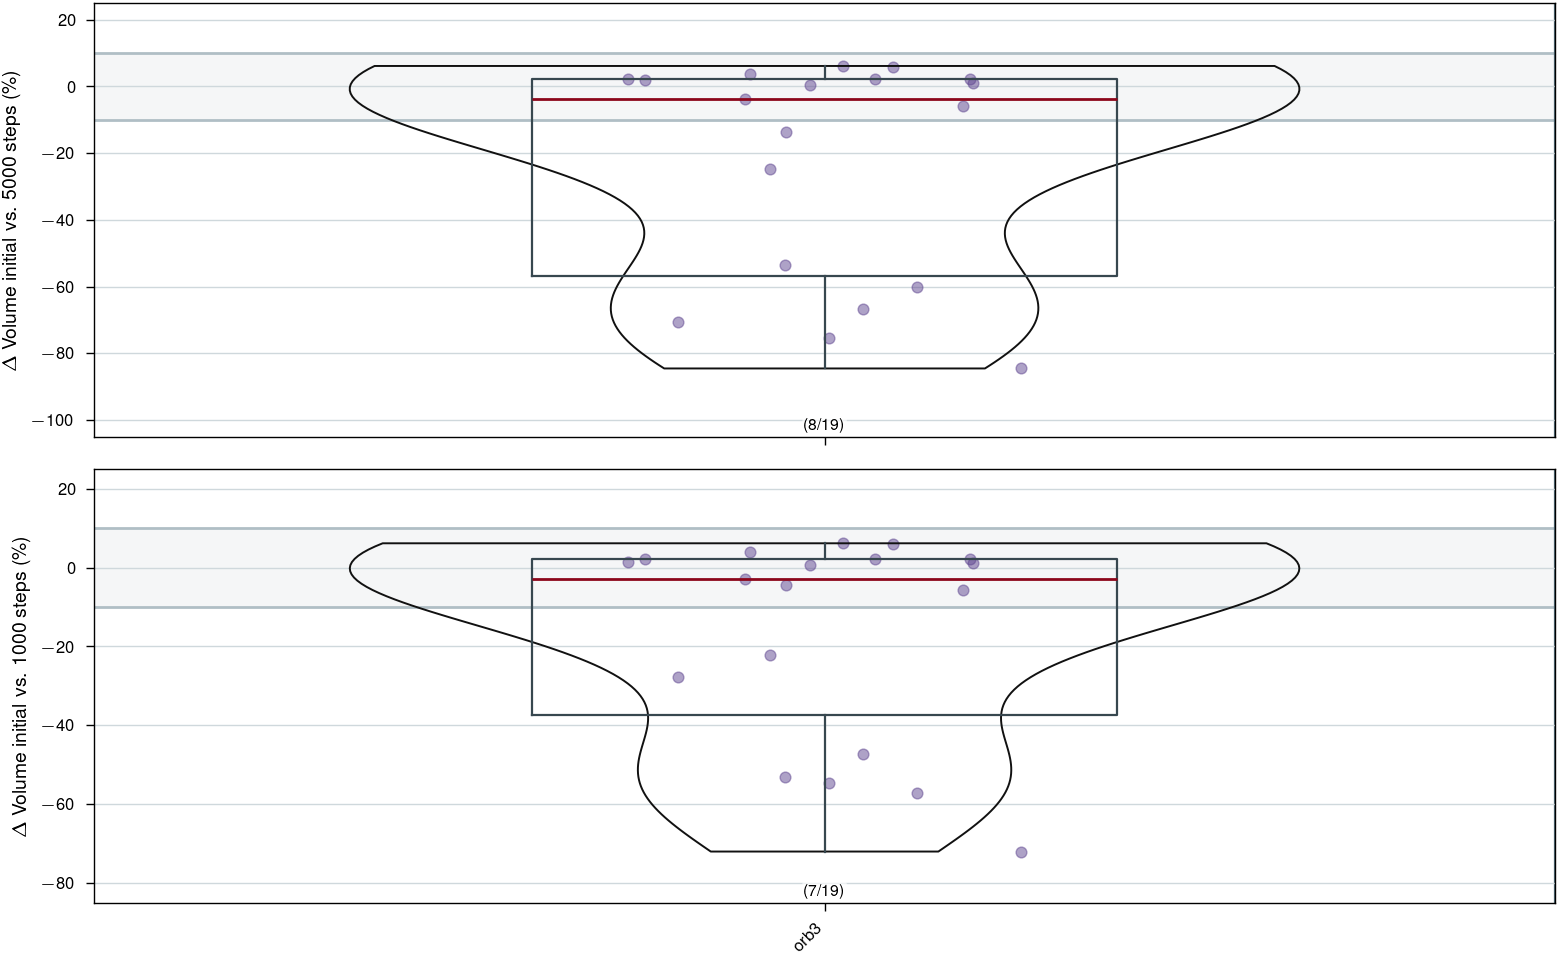

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(8,5), sharex=True)

ax = axs[0]

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

y_data = analysis_df
y_data = y_data[~y_data["vol_diff"].isna()]
failed_sum = y_data.groupby("calculator")["vol_diff"].agg(lambda x: (np.abs(x) > 10).sum())
y_data = y_data.groupby("calculator")["vol_diff"].apply(list).loc[all_calcs]

## VIOLIN PLOT
generate_violin_plot(y_data, ax, plot_density=False, scatter_kwargs={"s": 15, "rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([-105,25])
ax.set_xlim([-0.5, len(all_calcs) - 0.5])

rect = patches.Rectangle((-1, 10), len(all_calcs)+1, -20, linewidth=1, edgecolor="#B0BEC5", facecolor="#B0BEC5" + "20", zorder=-10)
ax.add_patch(rect) 

for x, calc in enumerate(all_calcs):
    ax.text(x, -104, f"({failed_sum.loc[calc]}/{len(y_data.loc[calc])})", horizontalalignment="center", verticalalignment="bottom", size=5.7, bbox=text_bbox)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.set_ylabel("$\\Updelta$ Volume initial vs. 5000 steps (\\%)", size=7)

ax = axs[1]

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

y_data = analysis_df
y_data = y_data[~y_data["vol_diff_1000"].isna()]
failed_sum = y_data.groupby("calculator")["vol_diff_1000"].agg(lambda x: (np.abs(x) > 10).sum())
y_data = y_data.groupby("calculator")["vol_diff_1000"].apply(list).loc[all_calcs]

## VIOLIN PLOT
generate_violin_plot(y_data, ax, plot_density=False, scatter_kwargs={"s": 15, "rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([-85,25])

rect = patches.Rectangle((-1, 10), len(all_calcs)+1, -20, linewidth=1, edgecolor="#B0BEC5", facecolor="#B0BEC5" + "20", zorder=-10)
ax.add_patch(rect) 

for x, calc in enumerate(all_calcs):
    ax.text(x, -84, f"({failed_sum.loc[calc]}/{len(y_data.loc[calc])})", horizontalalignment="center", verticalalignment="bottom", size=5.7, bbox=text_bbox)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.set_ylabel("$\\Updelta$ Volume initial vs. 1000 steps (\\%)", size=7)

fig.tight_layout()
fig.set_dpi(200)
fig.show()

fig.savefig("figures/opt_volume_change.pdf")

# Stability

In [86]:
# Load the data
stability_file = (
    base_dir / "analysis" / "results" / "stability_results.parquet"
)
    
stability_df = pd.read_parquet(stability_file)

ambient_settings = "stability_prod_mtk.yaml"

In [94]:
ambient_df = stability_df[stability_df.index.get_level_values("settings").str.endswith(ambient_settings)]

In [95]:
# Filter out structures that collapse for MACE-MP-MOF0

sel = ambient_df[ambient_df.index.get_level_values("calculator") == "mace_prod_mof"]
rel_volume = sel["volume_rel"].apply(lambda x: x[-1])
unstable_structures = rel_volume[abs(1-rel_volume) > 0.1].index.get_level_values("structure")

In [96]:
unstable_structures

Index([], dtype='object', name='structure')

In [97]:
last_step_relative_volume = []
last_step_rmsd_exp = []
for calc in all_calcs:
    df = ambient_df[
        (ambient_df.index.get_level_values("calculator") == calc)
        # & ~(ambient_df.index.get_level_values("structure").isin(unstable_structures))
    ]
    rel_volume = df["volume_rel"].apply(lambda x: x[-1])
    last_step_rmsd_exp.append(df["rmsd_exp"].apply(lambda x: x[-1]))
    last_step_relative_volume.append(rel_volume.values * 100 - 100)

In [98]:
failed_per_calculator = ambient_df[~ambient_df["volume_rel"].isna()].groupby("calculator")["volume_rel"].agg(lambda x: sum([np.abs(v[-1]-1) > 0.1 for v in x]))
successfully_computed_per_calculator = ambient_df[~ambient_df["volume_rel"].isna()].groupby("calculator")["volume_rel"].agg(len)

In [99]:
ambient_df.groupby("calculator")["volume_rel"].agg(len)

calculator
orb3    8
Name: volume_rel, dtype: int64

In [100]:
coordination_diff = []
for calc in all_calcs:
    df = stability_df[stability_df.index.get_level_values("calculator") == calc]
    calc_coord_diff = df["initial_coordination"] - df["final_coordination"]
    coordination_diff.append(np.hstack(calc_coord_diff.values))

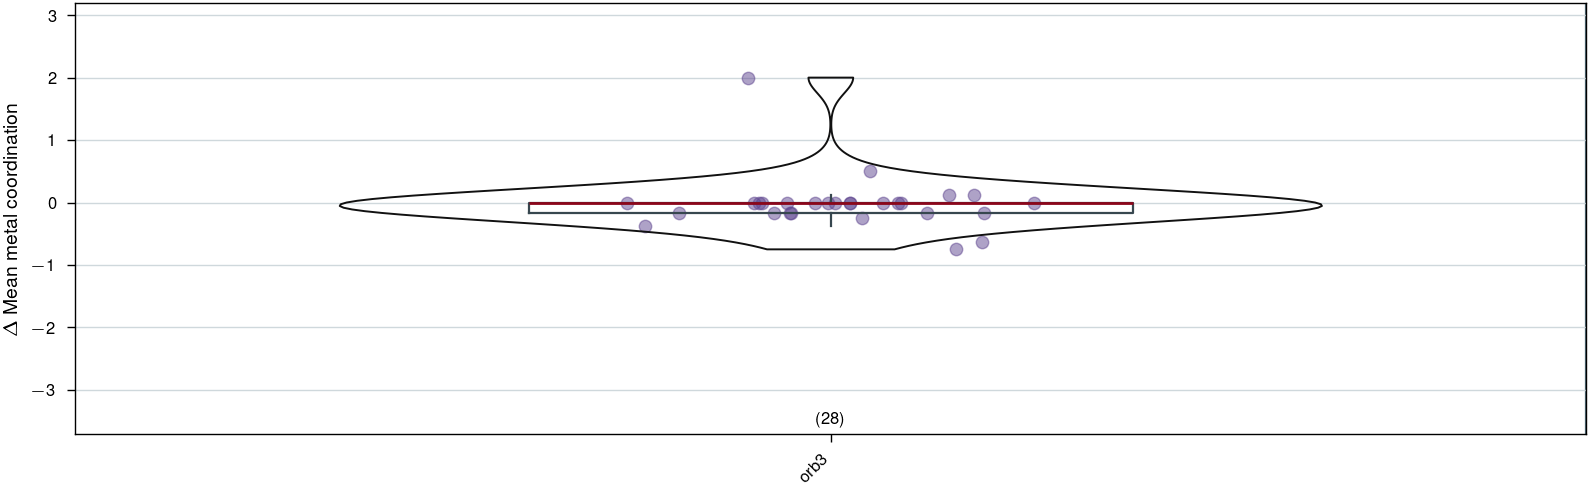

In [101]:
fig, ax = plt.subplots(figsize=(8,2.5))

generate_violin_plot(coordination_diff, ax=ax, plot_density=False, scatter_kwargs={"rasterized": True}, colors=cmap_all)
ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

for x, calc in enumerate(all_calcs):
    i = all_calcs.index(calc)
    ax.text(x, -3.6, f"({len(coordination_diff[i])})", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1"))

ax.set_ylabel("$\\Updelta$ Mean metal coordination", size=7)
ax.set_ylim([-3.7, 3.2])

fig.set_dpi(200)

fig.savefig("figures/stability_metal_coordination_all.pdf")

## Copper

In [102]:
copper_settings = "stability_prod_copper_mtk.yaml"
copper_coordination_df = stability_df[stability_df.index.get_level_values("settings").str.endswith(copper_settings)]
copper_coordination_df = copper_coordination_df.explode(["symbol", "initial_coordination", "final_coordination", "initial_coordination_1_1", "final_coordination_1_1", "initial_coordination_1_2", "final_coordination_1_2"])

In [103]:
copper_coordination_diff = []
for calc in all_calcs:
    df = copper_coordination_df[(copper_coordination_df.index.get_level_values("calculator") == calc) & (copper_coordination_df["symbol"] == "Cu")]
    calc_coord_diff_1 = df["final_coordination_1_1"] - df["initial_coordination_1_1"]
    calc_coord_diff_2 = df["final_coordination_1_2"] - df["initial_coordination_1_2"]
    calc_coord_diff_3 = df["final_coordination"] - df["initial_coordination"]
    calc_coord_diff = calc_coord_diff_1
    sel = np.abs(calc_coord_diff) > np.abs(calc_coord_diff_2)
    calc_coord_diff[sel] = calc_coord_diff_2[sel]
    sel = np.abs(calc_coord_diff) > np.abs(calc_coord_diff_3)
    #calc_coord_diff[sel] = calc_coord_diff_3[sel]
    copper_coordination_diff.append(np.hstack(calc_coord_diff.values))

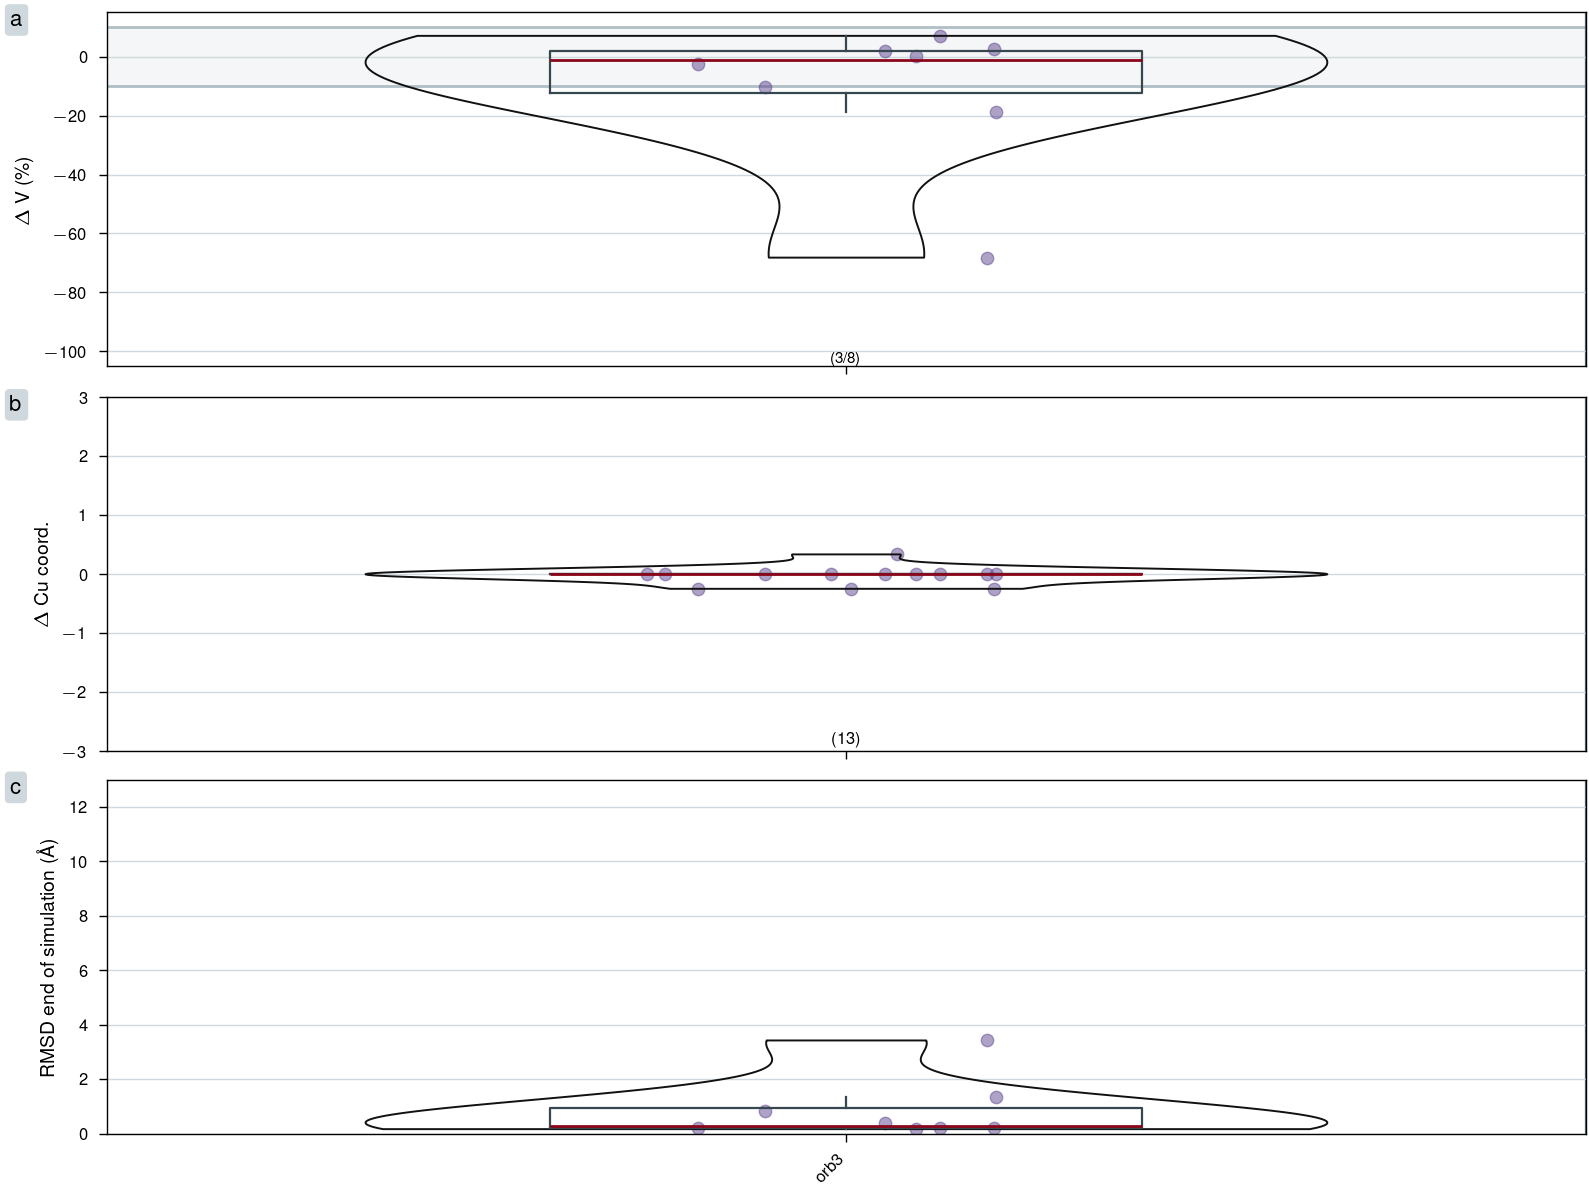

In [105]:
fig, axs = plt.subplots(3, figsize=(8,6), sharex=True)

ax = axs[0]

generate_violin_plot(last_step_relative_volume, ax, plot_density=False, scatter_kwargs={"rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([-105,15])
ax.set_ylabel("$\\Updelta$ V (\\%)", size=7)

rect = patches.Rectangle((-0.6, 10), len(all_calcs)+1, -20, linewidth=1, edgecolor="#B0BEC5", facecolor="#B0BEC5" + "20", zorder=-10)
ax.add_patch(rect)

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)
    
for x, calc in enumerate(all_calcs):
    i = all_calcs.index(calc)
    ax.text(x, -105, f"({failed_per_calculator.loc[calc]}/{len(last_step_relative_volume[i])})", horizontalalignment="center", verticalalignment="bottom", size=5.5)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.annotate(
    "a",
    xy=(-0.08, 1.07), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", pad=3.0, boxstyle="round,pad=0.25,rounding_size=0.2")
)
ax.annotate(
    ".", color="#ffffff00",alpha=0,
    xy=(-0.085, 1.09), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
)

ax = axs[1]

generate_violin_plot(copper_coordination_diff, ax=ax, plot_density=False, colors=cmap_all)
_ = ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")

ax.set_ylabel("$\\Updelta$ Cu coord.", size=7)

for x, calc in enumerate(all_calcs):
    i = all_calcs.index(calc)
    ax.text(x, -2.94, f"({len(copper_coordination_diff[i])})", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=text_bbox)

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.set_ylim([-3,3])
ax.set_xlim([-0.5, len(all_calcs)-0.5])

ax.annotate(
    "b",
    xy=(-0.08, 1.07), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", pad=3.0, boxstyle="round,pad=0.25,rounding_size=0.2")
)

ax = axs[2]

generate_violin_plot(last_step_rmsd_exp, ax, plot_density=False, scatter_kwargs={"rasterized": True}, colors=cmap_all)

ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")
ax.set_ylim([0,13])
ax.set_ylabel("RMSD end of simulation (\\AA)", size=7)

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

ax.annotate(
    "c",
    xy=(-0.08, 1.07), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", pad=3.0, boxstyle="round,pad=0.25,rounding_size=0.2")
)

fig.set_dpi(200)
fig.savefig("figures/stability_volume_copper_coordination_all.pdf")

## Increasing temp stability

In [108]:
temp_settings = "stability_prod_temp_mtk.yaml"

temp_stability_df = stability_df[stability_df.index.get_level_values("settings").str.endswith(temp_settings)]
# temp_stability_df = temp_stability_df.explode("symbol")

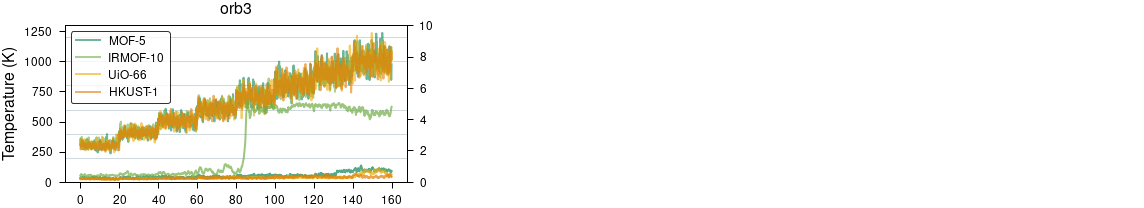

In [110]:
calcs = all_calcs

fig, ax = plt.subplots(np.ceil(len(calcs) / 3).astype(int), 3, figsize=(8, 0.5 * len(calcs)+1), sharex=True, sharey=True, constrained_layout=True)
ax = ax.ravel()

structures = included_structures

for i, calc in enumerate(calcs):
    
    y_axis = ax[i].twinx()
    
    for j, structure in enumerate(structures):
        try:
            sel = temp_stability_df[(temp_stability_df.index.get_level_values("calculator") == calc) & (temp_stability_df.index.get_level_values("structure") == structure)].iloc[0]
    
            idx = sel.stage > 1
            step = sel.step[idx] + (sel.stage[idx] - 2) * 20000
            temp = sel.temperature[idx]
            rmsd = sel.rmsd_exp[idx]
            ax[i].plot(step, temp, label = structure.replace("_primitive", ""), c=palette[j+3], alpha=0.6, rasterized=True)
            y_axis.plot(step, rmsd, c=palette[j+3], alpha=0.7, rasterized=True)
            
        except:
            pass

        ax[i].set_title(calc_names[calc].replace("\n", " "))
        ax[i].legend()

        ax[i].set_ylim([0,1300])
        if i in [20,19,18]:
            ax[i].set_xlabel("Time (ps)")
        if i % 3 == 0:
            ax[i].set_ylabel("Temperature (K)")
        if i % 3 == 2:
            y_axis.set_ylabel("RMSD (\\AA)")
        ax[i].set_xticks(np.arange(0, 160001, 20000), np.arange(0, 170, 20))
        y_axis.set_ylim([0,10])
    
        HLINES = np.arange(0, 1400, 200)
        if show_hlines:
            for h in HLINES:
                ax[i].axhline(h, color=GREY_LIGHT, lw=0.4, zorder=-10)
    
            #for h in HLINES + 100:
            #    ax[i].axhline(h, color=GREY_LIGHT, lw=0.2, zorder=-10)


    legend = ax[i].get_legend()
    if legend is not None:
        legend.remove()
        y_axis.add_artist(legend)

for i in range(len(calcs), np.ceil(len(calcs) / 3).astype(int) * 3):
    ax[i].set_axis_off()
    ax[i - 3].xaxis.set_tick_params(which="both", labelbottom=True)

# fig.tight_layout()
fig.savefig("figures/stability_temp.pdf")

# Bulk modulus

In [112]:
bulk_modulus_file = base_dir / "analysis" / "results" / "bulk_modulus_results.parquet"
bulk_modulus_results = pd.read_parquet(bulk_modulus_file)

selected_settings = "bulk_modulus.yaml"

In [113]:
bulk_modulus_df = bulk_modulus_results[(bulk_modulus_results.index.get_level_values("settings").str.endswith(selected_settings))]

In [ ]:
bulk_modulus_diff = []
bulk_modulus_rmse = []
bulk_modulus_mae = []
bulk_modulus_se = []

all_calcs_bm = all_calcs
exclude_failed = True

for calc in all_calcs_bm:
    df = bulk_modulus_df[bulk_modulus_df.index.get_level_values("calculator") == calc]
    if len(df) == 0:
        bulk_modulus_diff.append(None)
        bulk_modulus_rmse.append(None)
        continue
    #print(f"{calc} failed {df[df["B"].isna()].index.get_level_values("structure").values}")
    if len(df[(~df["dft_B"].isna()) & (df["B"].isna())]) > 0:
        print(calc, df[(~df["dft_B"].isna()) & (df["B"].isna())].index.get_level_values("structure").values)
    df = df[(~df["dft_B"].isna()) & (~df["B"].isna())]
    if exclude_failed:
        opt_volumes = df["volumes"].apply(lambda x: x[5])
        failed = abs((opt_volumes - df["v0"]) / opt_volumes) > 0.01
        df = df[~failed]
    print(calc, len(df))
    values = (df["B"] - df["dft_B"]).values
    values = values[~np.isnan(values)]
    bulk_modulus_diff.append(values)
    bulk_modulus_rmse.append(root_mean_squared_error(df["dft_B"], df["B"]))
    bulk_modulus_mae.append(np.mean(np.abs(df["dft_B"] - df["B"])))
    bulk_modulus_se.append(np.std(np.abs(df["dft_B"] - df["B"]))/len(df["dft_B"]))

np.mean(bulk_modulus_rmse[:-2]), np.mean(bulk_modulus_mae[:-2])

orb3 21


/home/tu/tu_tu/tu_zxoyu44/miniforge3/envs/mb_orb3/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/tu_tu/tu_zxoyu44/miniforge3/envs/mb_orb3/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tu/tu_tu/tu_zxoyu44/miniforge3/envs/mb_orb3/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/tu_tu/tu_zxoyu44/miniforge3/envs/mb_orb3/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(np.float64(nan), np.float64(nan))

v4, 0.04, 44.5, 13.34  
v5, 0.02, 716.08, 98.45  
v6, 0.01, 166.29, 49.9  
v7, 0.08, 74.0, 16.21

In [117]:
df = bulk_modulus_df[bulk_modulus_df.index.get_level_values("calculator") == "mace_prod_mof"]

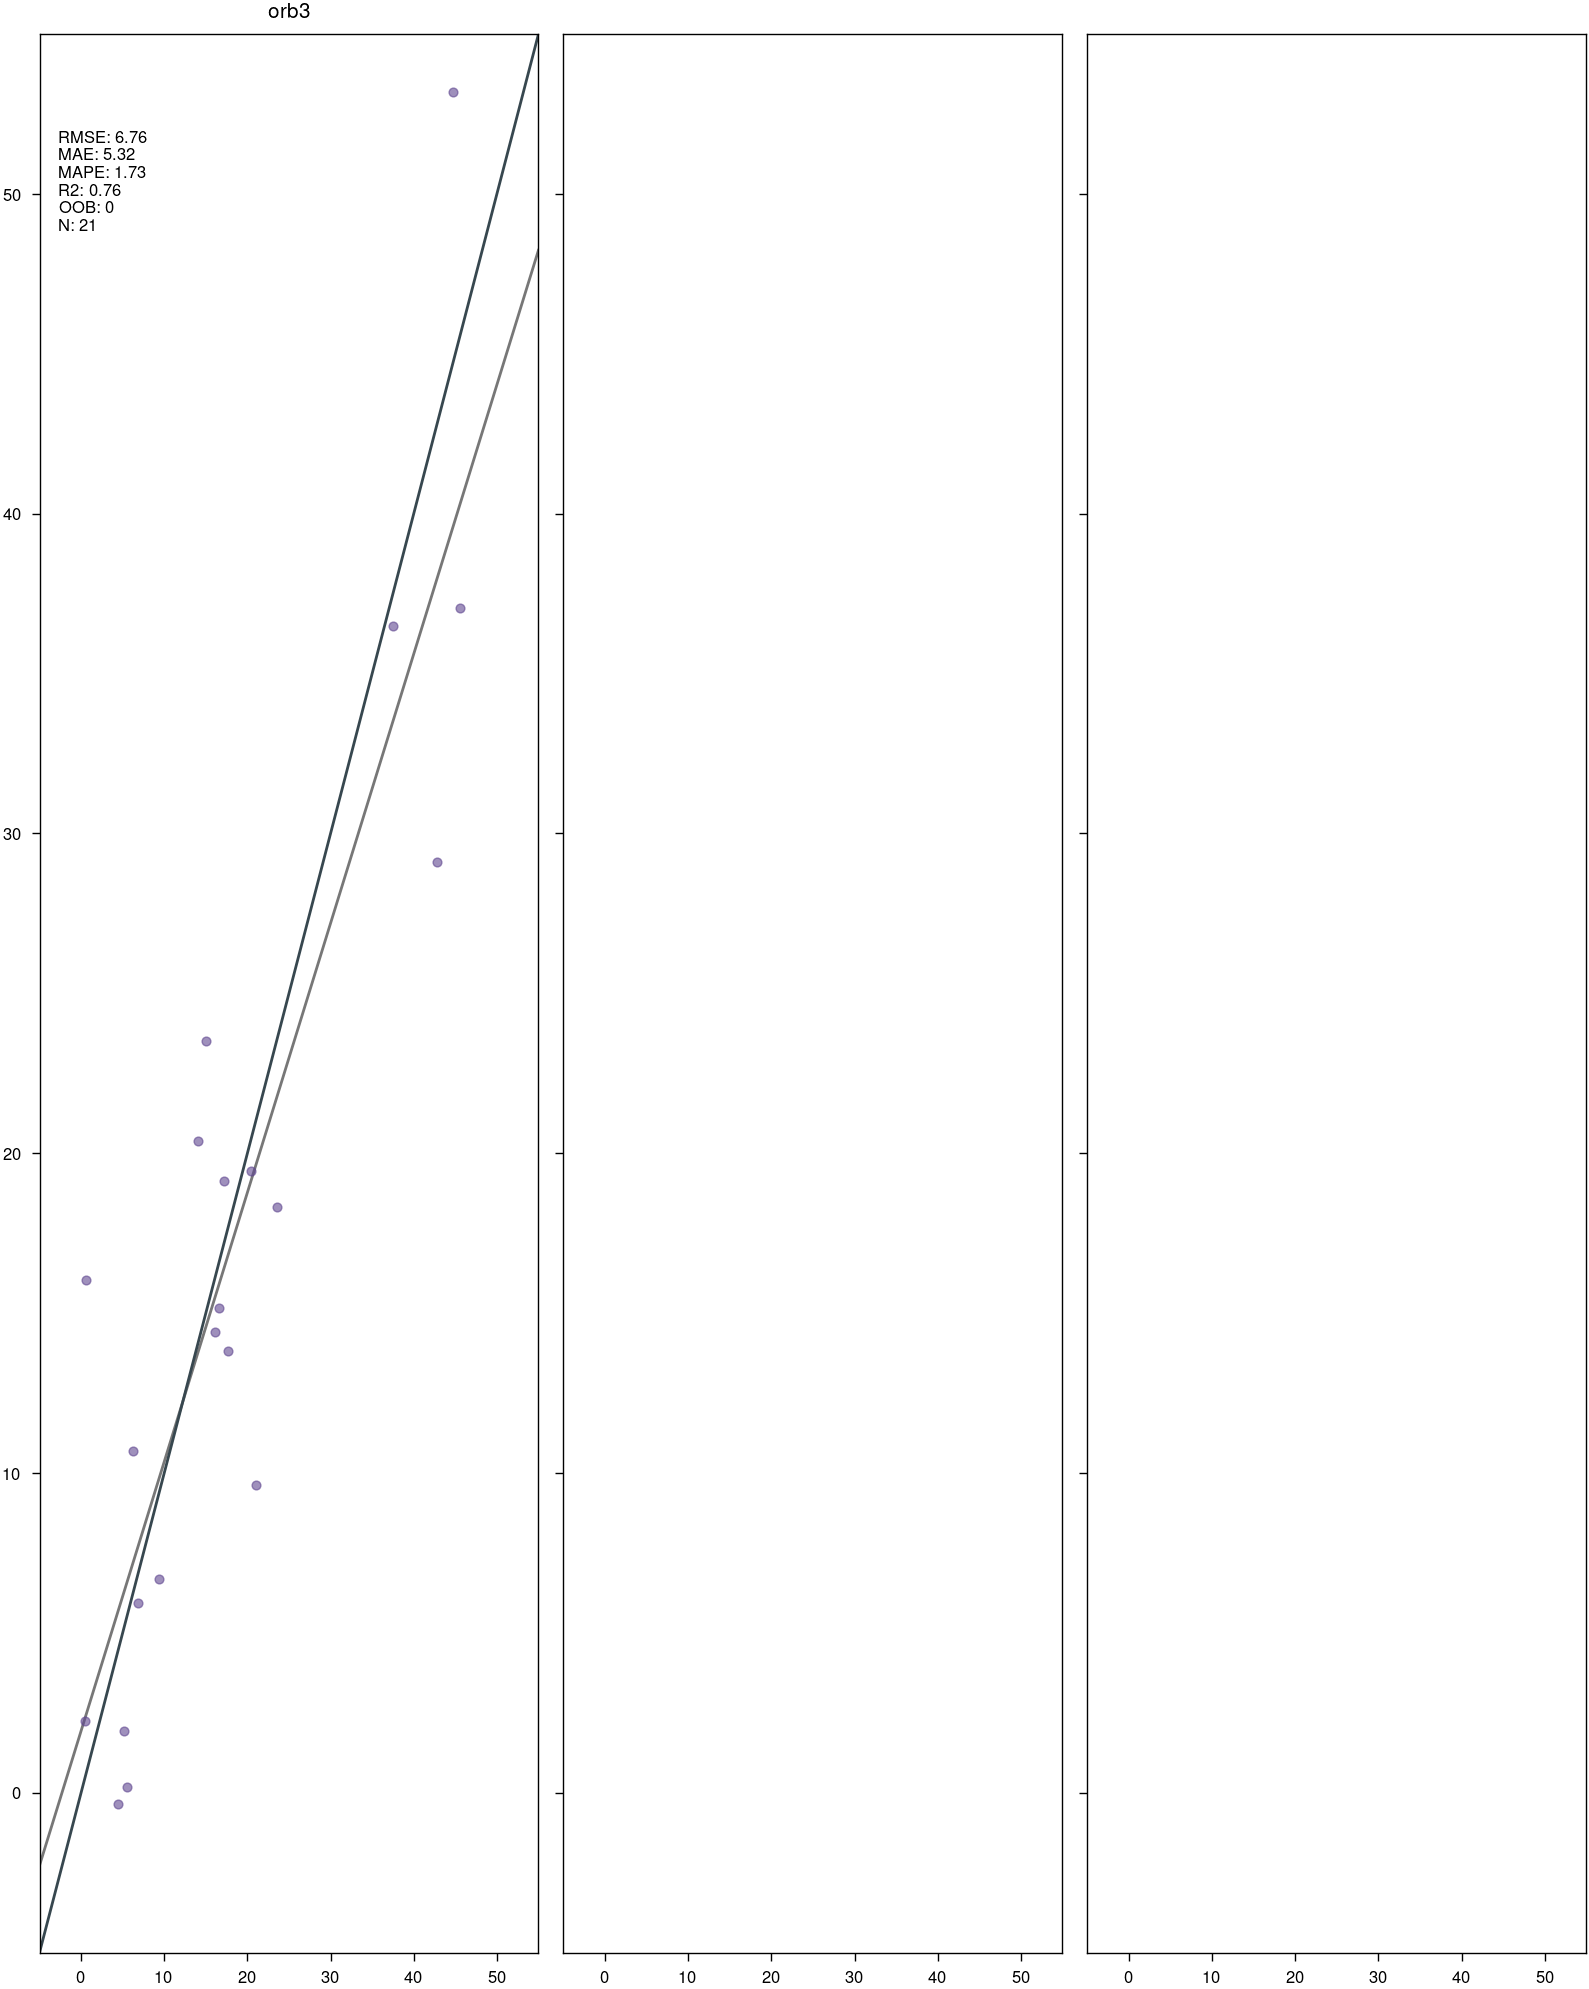

In [ ]:
ncols = 3
figheight, figwidth = 10, 8

calculators = bulk_modulus_df.index.get_level_values("calculator").unique()
calculators = all_calcs_bm

exclude_failed = True

b_min, b_max = -5, 95

nrows = int(np.ceil(len(calculators) / ncols))

fig, ax = plt.subplots(
    nrows,
    ncols,
    figsize=(figwidth, figheight),
    sharey=True,
    sharex=True,
    constrained_layout=True
)

for i, calc in enumerate(calculators):

    y = i // ncols
    x = i % ncols

    df = bulk_modulus_df[bulk_modulus_df.index.get_level_values("calculator") == calc]
    df = df[(~df["dft_B"].isna()) & (~df["B"].isna())]
    num_failed = 0
    if exclude_failed:
        opt_volumes = df["volumes"].apply(lambda x: x[5])
        failed = abs((opt_volumes - df["v0"]) / opt_volumes) > 0.01
        num_failed = sum(failed)
        df = df[~failed]

    rmse = root_mean_squared_error(df["dft_B"], df["B"])
    mae = np.mean(np.abs(df["dft_B"] - df["B"]))
    mape = mean_absolute_percentage_error(df["dft_B"], df["B"])
    r2 = r2_score(df["dft_B"], df["B"])
    ybounds = b_min, b_max
    xbounds = b_min, b_max
    oob = np.sum((df["B"] > ybounds[1]) | (df["B"] < ybounds[0]) | (df["dft_B"] < xbounds[0]) | (df["dft_B"] > xbounds[1]))
    m, b = np.polyfit(df["dft_B"].values, df["B"].values, 1)

    poly_x = np.linspace(b_min, b_max, 2)
    poly_y = poly_x * m + b
    ax[y][x].plot(poly_x, poly_y, c="#777", zorder=-10)
    
    ax[y][x].scatter(df["dft_B"], df["B"], s=10, c=[cmap_all[all_calcs.index(calc)]], alpha=0.6)
    ax[y][x].plot([b_min, b_max], [b_min, b_max], c=GREY_DARK, zorder=-10)
    ax[y][x].set_xlim([b_min, b_max])
    ax[y][x].set_ylim(ybounds)
    ax[y][x].set_title(calc_names[calc].replace("\n", " "), size=7.5)
    ax[y][x].text(0.03, 0.95, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}\nR2: {r2:.2f}\nOOB: {oob}\nFailed: {num_failed}\nN: {len(df)}", horizontalalignment="left", verticalalignment="top", transform = ax[y][x].transAxes, size=6)
    # ax[y][x].grid(alpha=0.5)

for y in range(nrows):
    ax[y][0].set_ylabel("Bulk modulus uMLIP (GPa)", size=7)
for x in range(ncols):
    ax[nrows-1][x].set_xlabel("Bulk modulus DFT (GPa)", size=7)


# fig.tight_layout()
fig.set_dpi(200)
fig.savefig("figures/bulk_modulus_parity_all_no_failed.pdf")

### ESMOFs:

In [126]:
esmofs = ["MOF-5_primitive", "IRMOF-10_primitive", "UiO-66_primitive", "HKUST-1_primitive"]

df = bulk_modulus_df[bulk_modulus_df.index.get_level_values("structure").isin(esmofs)]

for calc in all_calcs:
    uio = df[(df.index.get_level_values("calculator") == calc) & (df.index.get_level_values("structure") == esmofs[2])].iloc[0]["B"]
    mof5 = df[(df.index.get_level_values("calculator") == calc) & (df.index.get_level_values("structure") == esmofs[0])].iloc[0]["B"]
    irmof10 = df[(df.index.get_level_values("calculator") == calc) & (df.index.get_level_values("structure") == esmofs[1])].iloc[0]["B"]
    hkust = df[(df.index.get_level_values("calculator") == calc) & (df.index.get_level_values("structure") == esmofs[3])].iloc[0]["B"]

In [127]:
mof_images = [
    "mof_viz/MOF5_per_no_cell_poly_alpha_v2.png",
    "mof_viz/irmof-10_per_nocell_poly_alpha.png",
    "mof_viz/uio-66_per_nocell_poly_alpha_color_v2.png",
    "mof_viz/HKUST-1_per_nocell_poly_alpha.png",
    "mof_viz/legend_esmofs.png"
]

In [128]:
from PIL import Image
def open_image_local(path_to_image):
    image = Image.open(path_to_image) # Open the image
    image_array = np.array(image) # Convert to a numpy array
    return image_array # Output

images = [open_image_local(img) for img in mof_images]

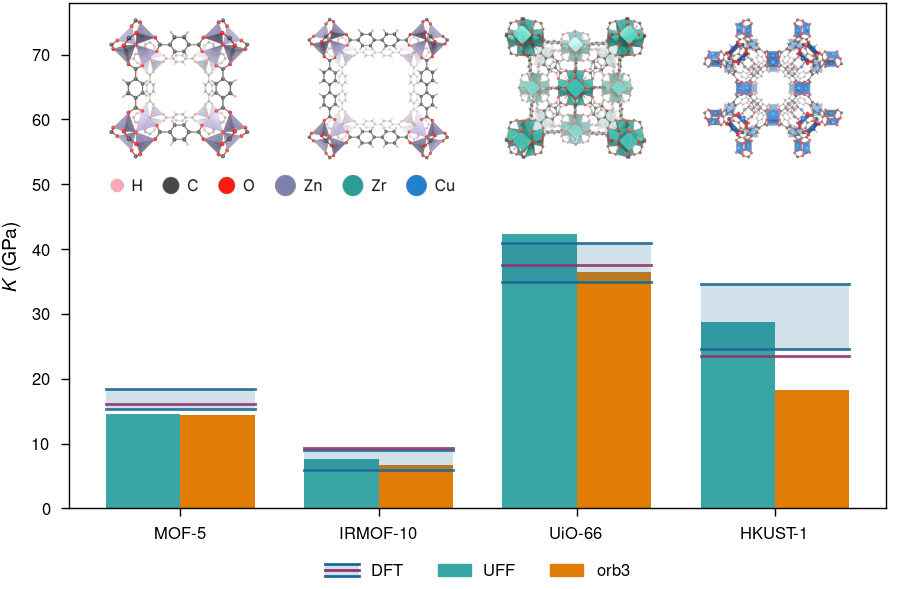

In [131]:
fig, ax = plt.subplots(figsize=(4.5,3))

df = bulk_modulus_df[bulk_modulus_df.index.get_level_values("structure").isin(esmofs)]
width = 1.5 / (len(all_calcs)+1)
x = np.linspace(0,width * len(all_calcs),len(all_calcs)+1)

mof5_dft = np.asarray([
    16.3, # 10.1103/PhysRevB.76.184106 (DFT)
    15.34, # 10.1002/pssb.201100634 (DFTB)
    18.5, # 10.1063/1.2337287 (DFT/VASP)
    17.02, # 10.1103/PhysRevB.73.094111 (DFT)
    18.20, # 10.1103/PhysRevB.74.180301 (DFT)
    15.95, # 10.1038/s41524-025-01611-8 (DFT)
])
irmof10_dft = np.asarray([
    6.0, # 10.1021/jp072085x (DFT)
    9.09, # 10.1039/C1RA00187F (DFT)
    8.6, # 10.1038/s41524-025-01611-8 (DFT)
])
uio_dft = np.asarray([
    41.01, # 10.1021/jz4002345 (DFT)
    35.00, # 10.1038/s41524-025-01611-8 (DFT)
])
hkust_dft = np.asarray([
    24.53, # 10.1021/jz4002345 (DFT)
    34.66, # 10.1002/pssb.201100634 (DFT)
])
# our DFT, UFF 2017
mof5s = [16.062275, 14.5]
irmof10s = [9.399284, 7.6]
uios = [37.499708, 42.4]
hkusts = [23.581468, 28.7]
for i, calc in enumerate(all_calcs):
    calc_filter = df.index.get_level_values("calculator") == calc
    uio = df[calc_filter & (df.index.get_level_values("structure") == esmofs[2])].iloc[0]["B"]
    mof5 = df[calc_filter & (df.index.get_level_values("structure") == esmofs[0])].iloc[0]["B"]
    irmof10 = df[calc_filter & (df.index.get_level_values("structure") == esmofs[1])].iloc[0]["B"]
    hkust = df[calc_filter & (df.index.get_level_values("structure") == esmofs[3])].iloc[0]["B"]
    uios.append(max(uio, 0))
    hkusts.append(max(hkust, 0))
    mof5s.append(max(mof5, 0))
    irmof10s.append(max(irmof10, 0))
    
# colors = [palette[2], palette[3]] + [palette[5][:-2]+f"{a}{a}" for a in "579bdf"][::-1]
colors = [palette[2], palette[6]] + [adjust_lightness(palette[5], v) for v in np.linspace(1,2,len(all_calcs))]
ax.bar(x, [mof5s[1]] + [mof5s[2:][all_calcs.index(calc)] for calc in all_calcs], width, label="MOF-5", color = colors)
ax.bar(x + 2, [irmof10s[1]] + [irmof10s[2:][all_calcs.index(calc)] for calc in all_calcs], width, label="IRMOF-10", color = colors)
ax.bar(x + 4, [uios[1]] + [uios[2:][all_calcs.index(calc)] for calc in all_calcs], width, label="UiO-66", color = colors)
ax.bar(x + 6, [hkusts[1]] + [hkusts[2:][all_calcs.index(calc)] for calc in all_calcs], width, label="HKUST-1", color = colors)

# DFT bars
min_offset = -width/2
max_offset = width * (len(all_calcs) + 0.5)
ax.plot([min_offset, max_offset], [mof5_dft.max(), mof5_dft.max()], c=palette[1], alpha=0.9)
ax.plot([min_offset, max_offset], [mof5_dft.min(), mof5_dft.min()], c=palette[1], alpha=0.9)
ax.fill_between([min_offset, max_offset], [mof5_dft.min(), mof5_dft.min()], [mof5_dft.max(), mof5_dft.max()], fc=palette[1], alpha=0.2)
ax.plot([min_offset, max_offset], [mof5s[0], mof5s[0]], c=palette[8], alpha=0.9)

ax.plot([2+min_offset, 2+max_offset], [irmof10_dft.max(), irmof10_dft.max()], c=palette[1], alpha=0.9)
ax.plot([2+min_offset, 2+max_offset], [irmof10_dft.min(), irmof10_dft.min()], c=palette[1], alpha=0.9)
ax.fill_between([2+min_offset, 2+max_offset], [irmof10_dft.min(), irmof10_dft.min()], [irmof10_dft.max(), irmof10_dft.max()], fc=palette[1], alpha=0.2)
ax.plot([2+min_offset, 2+max_offset], [irmof10s[0], irmof10s[0]], c=palette[8], alpha=0.9)

ax.plot([4+min_offset, 4+max_offset], [uio_dft.max(), uio_dft.max()], c=palette[1], alpha=0.9)
ax.plot([4+min_offset, 4+max_offset], [uio_dft.min(), uio_dft.min()], c=palette[1], alpha=0.9)
ax.fill_between([4+min_offset, 4+max_offset], [uio_dft.min(), uio_dft.min()], [uio_dft.max(), uio_dft.max()], fc=palette[1], alpha=0.2)
ax.plot([4+min_offset, 4+max_offset], [uios[0], uios[0]], c=palette[8], alpha=0.9)

ax.plot([6+min_offset, 6+max_offset], [hkust_dft.max(), hkust_dft.max()], c=palette[1], alpha=0.9)
ax.plot([6+min_offset, 6+max_offset], [hkust_dft.min(), hkust_dft.min()], c=palette[1], alpha=0.9)
polycollection = ax.fill_between([6+min_offset, 6+max_offset], [hkust_dft.min(), hkust_dft.min()], [hkust_dft.max(), hkust_dft.max()], fc=palette[1], alpha=0.2)
ax.plot([6+min_offset, 6+max_offset], [hkusts[0], hkusts[0]], c=palette[8], alpha=0.9)


# custom legend handler
class HandlerFilledBetween(matplotlib.legend_handler.HandlerPolyCollection):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        p = super().create_artists(legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans)[0]
        x0, y0 = p.get_x(), p.get_y()
        x1 = x0 + p.get_width()
        y1 = y0 + p.get_height()
        line_upper = mlines.Line2D([x0, x1], [y1, y1], color=palette[1])
        line_lower = mlines.Line2D([x0, x1], [y0, y0], color=palette[1])
        line_middle = mlines.Line2D([x0, x1], [(y0+y1)/2, (y0+y1)/2], color=palette[8])
        return [p, line_upper, line_lower, line_middle]


lines = [polycollection] + [mpatches.Patch(color=c) for c in colors]
labels = ["DFT", "UFF"] + [calc_names[key].replace("\n", " ") for key in all_calcs]

ax.legend(lines,
          labels,
          loc="upper center",
          bbox_to_anchor=(0.5, -0.08),
          ncol=3,
          handler_map={matplotlib.collections.PolyCollection: HandlerFilledBetween()},
          frameon=False
         )

ax.set_xticks(0.75+np.arange(0,7,2) + min_offset, [v.replace("_primitive", "") for v in esmofs])
ax.set_ylabel("$K$ (GPa)", size=7)
ax.set_ylim([0,69+9])

for i, img in enumerate(images[:4]):
    ax_image = fig.add_axes([
        0.06 + 0.22*i,
        0.7,
        0.29,
        0.29]
    )

    ax_image.imshow(img)
    ax_image.axis('off')

ax_image = fig.add_axes([
    0.12,
    0.605,
    0.4,
    0.15]
)

ax_image.imshow(images[-1])
ax_image.axis('off')

fig.set_dpi(200)
fig.savefig("figures/bulk_modulus_esmof.pdf", dpi=300)

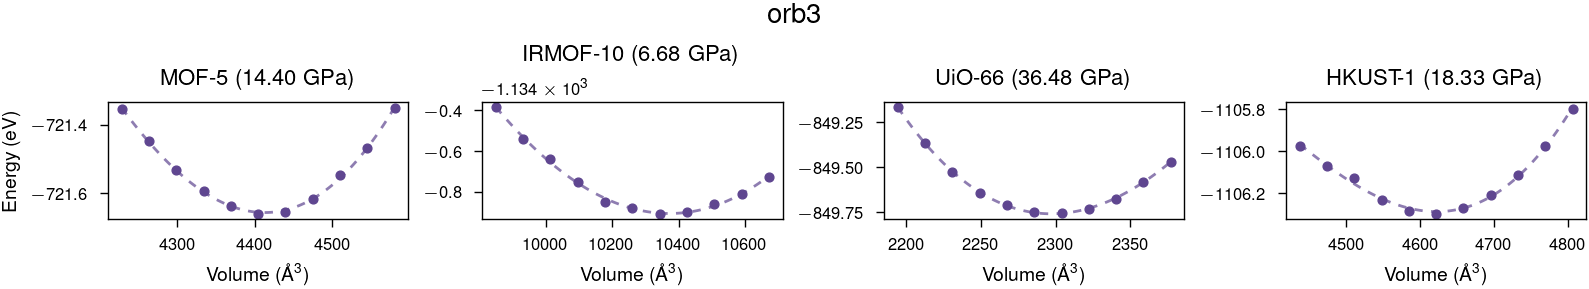

In [136]:
index = 0
rows_per_fig = 7
bm_calcs = all_calcs[index * rows_per_fig:(index + 1) * rows_per_fig]

fig = plt.figure(constrained_layout=True, figsize=(8,1.5 * len(bm_calcs)))

subfigs = fig.subfigures(nrows=len(bm_calcs), ncols=1)
if not isinstance(subfigs, np.ndarray):
    subfigs = [subfigs]
for i, subfig in enumerate(subfigs):
    calc = bm_calcs[i]
    t = calc_names[calc].replace('\n', ' ')
    subfig.suptitle(f"{t}", size=10)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=4)
    for j, ax in enumerate(axs):
        structure = esmofs[j]
        values = df[(df.index.get_level_values("calculator") == calc) & (df.index.get_level_values("structure") == structure)].iloc[0]
        label = ""
        c = [cmap_all[all_calcs.index(calc)]]
        try:
            eos = EquationOfState(
                values["volumes"],
                values["energies"],
                eos="birchmurnaghan",
            )
            v0, e0, B = eos.fit(warn=False)
            plot_data = eos.getplotdata()
            ax.plot(plot_data[-4], plot_data[-3], c=c[0], ls=(0, (3,3)), alpha=0.7)
            label = f"{B / units.kJ * 1.0e24:.2f}"
            pass
        except:
            pass
        ax.scatter(values["volumes"], values["energies"], s=10, c=c)
        if label != "":
            ax.set_title(f"{structure.replace('_primitive', '')} ({label} GPa)")
        else:
            ax.set_title(f"{structure.replace('_primitive', '')} (not converged)")

        if i == len(subfigs) - 1:
            ax.set_xlabel("Volume (\\AA$^3$)", size=7)

        if j == 0:
            ax.set_ylabel("Energy (eV)", size=7)

fig.set_dpi(200)
fig.savefig(f"figures/bulk_modulus_eos_all_{index}.pdf")

# Heat capacity

In [137]:
heat_capacity_file = base_dir / "analysis" / "results" / "heat_capacity_results.parquet"
heat_capacity_results = pd.read_parquet(heat_capacity_file)
selected_settings = "heat_capacity.yaml"

In [138]:
heat_capacity_df = heat_capacity_results[(heat_capacity_results.index.get_level_values("settings").str.endswith(selected_settings))]

In [139]:
temp_300_index = np.where(heat_capacity_df.iloc[0]["temperatures"] == 300)[0][0]
heat_capacity_df.loc[:, "cv_300"] = heat_capacity_df["heat_capacity_g"].apply(lambda x: x[temp_300_index])

In [140]:
heat_capacity_diff = []
heat_capacity_rmse = []
heat_capacity_mae = []
for calc in all_calcs:
    df = heat_capacity_df[heat_capacity_df.index.get_level_values("calculator") == calc]
    df = df[(~df["cv_300"].isna()) & (~df["dft_cv"].isna())]
    heat_capacity_diff.append((df["cv_300"] - df["dft_cv"]).values)
    if len(df["cv_300"])>0:
        heat_capacity_rmse.append(root_mean_squared_error(df["cv_300"], df["dft_cv"]))
        heat_capacity_mae.append(np.mean(np.abs(df["cv_300"] - df["dft_cv"])))
    else:
        heat_capacity_rmse.append(np.inf)
        heat_capacity_mae.append(np.inf)

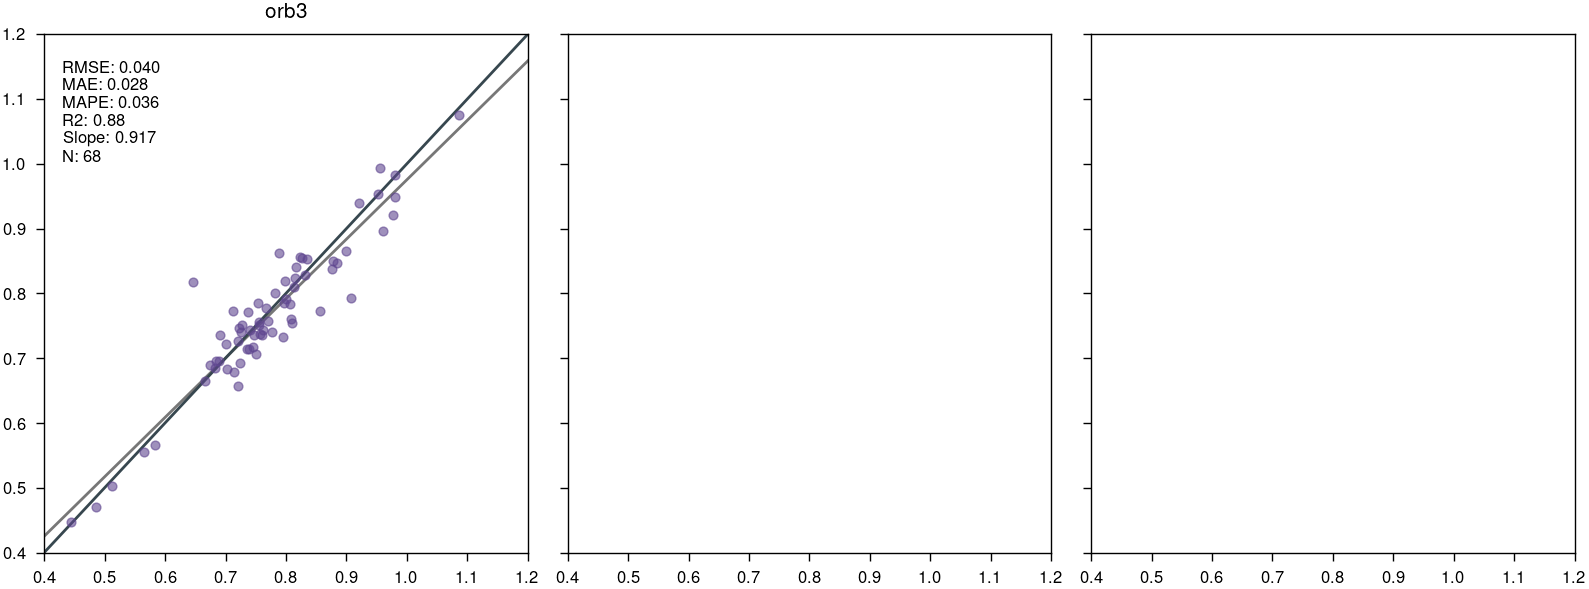

In [143]:
ncols = 3
figheight, figwidth = 3, 8

calculators = heat_capacity_df.index.get_level_values("calculator").unique()
calculators = all_calcs

nrows = int(np.ceil(len(calculators) / ncols))

fig, ax = plt.subplots(
    nrows,
    ncols,
    figsize=(figwidth, figheight),
    sharey=True,
    sharex=True,
    constrained_layout=True
)

ax = ax.ravel()

for i, calc in enumerate(calculators):

    df = heat_capacity_df[(heat_capacity_df.index.get_level_values("calculator") == calc) & (~heat_capacity_df["dft_cv"].isna())]
    df = df[(~df["dft_cv"].isna()) & (~df["cv_300"].isna())]

    rmse = root_mean_squared_error(df["dft_cv"], df["cv_300"])
    mape = mean_absolute_percentage_error(df["dft_cv"], df["cv_300"])
    mae = np.mean(np.abs(df["dft_cv"] - df["cv_300"]))
    r2 = r2_score(df["dft_cv"], df["cv_300"])
    m,b = np.polyfit(df["dft_cv"], df["cv_300"], 1)

    poly_x = np.linspace(0.4,1.2, 2)
    poly_y = poly_x * m + b
    ax[i].plot(poly_x, poly_y, c="#777", zorder=-10)
    
    ax[i].scatter(df["dft_cv"], df["cv_300"], s=10, color=cmap_all[all_calcs.index(calc)], alpha=0.6, rasterized=True)
    ax[i].plot([0.4,1.25], [0.4,1.25], c=GREY_DARK, zorder=-10)
    ax[i].set_xlim([0.4,1.2])
    ax[i].set_ylim([0.4,1.2])
    ax[i].set_title(calc_names[calc].replace("\n", " "), size=7.5)
    ax[i].text(0.04, 0.95, f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nMAPE: {mape:.3f}\nR2: {r2:.2f}\nSlope: {m:.3f}\nN: {len(df)}", horizontalalignment="left", verticalalignment="top", transform = ax[i].transAxes, size=6)


# fig.tight_layout()
fig.set_dpi(200)
fig.savefig("figures/heat_capacity_parity_all.pdf")

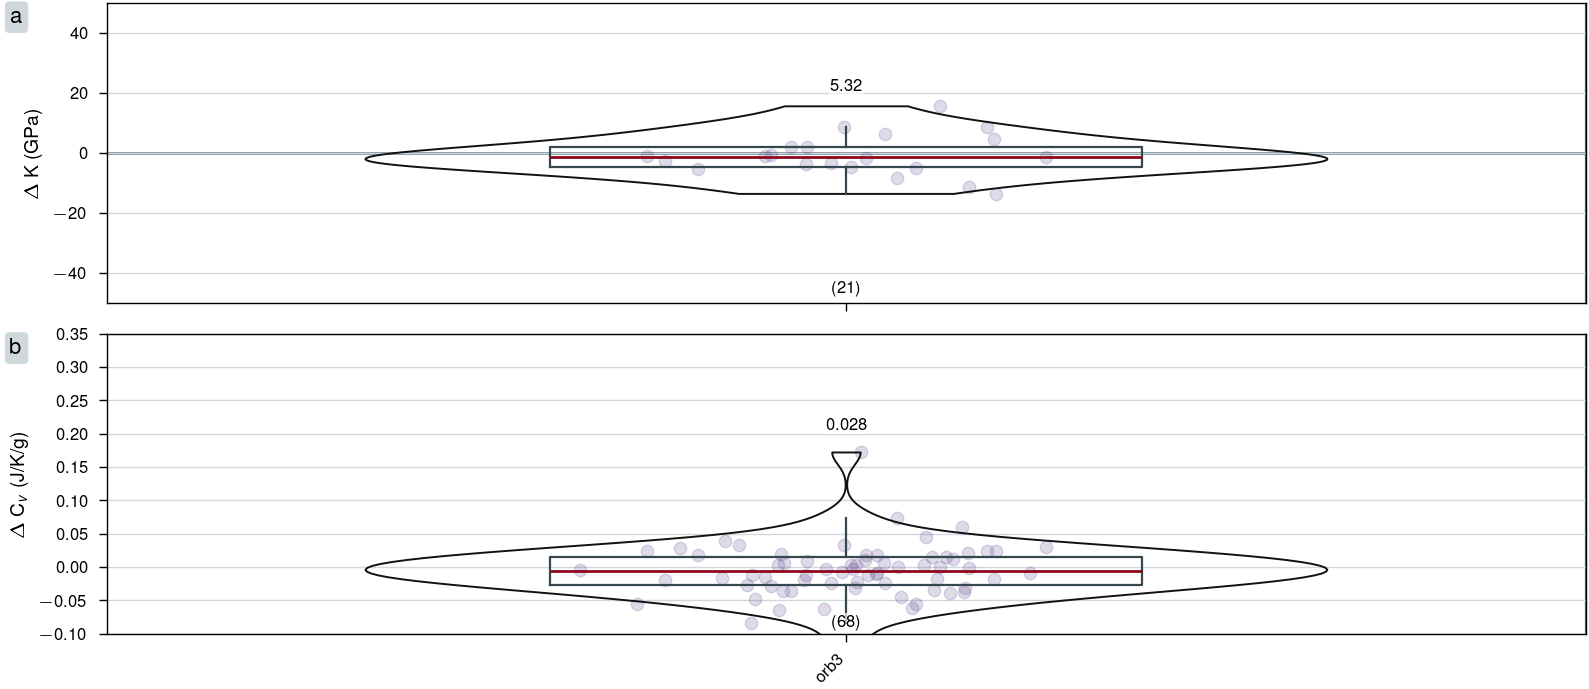

In [144]:
fig, axs = plt.subplots(2, sharex=True, figsize=(8,3.5))

ax = axs[0]
generate_violin_plot(bulk_modulus_diff, ax=ax, scatter_kwargs={"alpha": 0.2, "rasterized": True}, plot_density=False, colors=cmap_all)
ax.set_ylabel(r"$\Updelta$ K (GPa)", size=7)

if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)
ax.axhline(0, color=GREY, alpha=0.8, zorder=0)
    
# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)

for x, calc in enumerate(all_calcs):
    i = all_calcs.index(calc)
    ax.text(x, min(bulk_modulus_diff[i].max() + 4, 40), f"{bulk_modulus_mae[i]:.2f}", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1"))
    ax.text(x, -48, f"({len(bulk_modulus_diff[i])})", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1"))  

ax.set_ylim([-50, 50])
ax.annotate(
    "a",
    xy=(-0.08, 1.06), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", pad=3.0, boxstyle="round,pad=0.25,rounding_size=0.2")
)
ax.annotate(
    ".", color="#ffffff00",
    xy=(-0.085, 1.06), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
)

ax = axs[1]

generate_violin_plot(heat_capacity_diff, ax=ax, scatter_kwargs={"alpha": 0.2, "rasterized": True}, plot_density=False, colors=cmap_all)
_ = ax.set_xticks(np.arange(len(all_calcs)), [calc_names[key] for key in all_calcs], rotation=45, ha="right")

ax.set_ylim([-0.1,0.35])
ax.set_xlim([-0.5, len(all_calcs)-0.5])
if show_hlines:
    ax.grid(axis="y", color=GREY_LIGHT, lw=0.5, zorder=-100)

# vertical bar to separate MACE-MP-MOF0
ax.axvline(0.5, color=GREY, zorder=0, linewidth = 0.8)
  
for x, calc in enumerate(all_calcs):
    i = all_calcs.index(calc)
    ax.text(x, min(heat_capacity_diff[i].max() + 0.03, 0.3), f"{heat_capacity_mae[i]:.3f}", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1"))
    ax.text(x, -0.095, f"({len(heat_capacity_diff[i])})", horizontalalignment="center", verticalalignment="bottom", size=6, bbox=dict(facecolor="#ffffffaa", edgecolor="None", boxstyle="round,pad=0.1"))

ax.set_ylabel("$\\Updelta$ C$_v$ (J/K/g)", size=7)
ax.annotate(
    "b",
    xy=(-0.08, 1.06), xycoords="axes fraction",
    xytext=(+1, -1), textcoords="offset fontsize",
    fontsize="8", verticalalignment="top",
    bbox=dict(facecolor=GREY_LIGHT, edgecolor="none", pad=3.0, boxstyle="round,pad=0.25,rounding_size=0.2")
)

fig.set_dpi(200)
fig.savefig("figures/bm_hc_all.pdf")